In [220]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

time: 835 µs (started: 2021-08-09 10:51:15 +00:00)


## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

# Project

In [2]:
data_dir = '~/aiffel/000Projects/EX6/data/data'


train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

data = pd.read_csv(train_data_path)
sub = pd.read_csv(test_data_path)

print('Done')

Done


In [3]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [4]:
# date 정리 -> month만
data['date'] = data['date'].apply(lambda i: i[:6]).astype(int)
data['date'] = data['date'].astype('category').cat.codes
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,5,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,9,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,9,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,1,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,8,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [5]:
# 타깃 컬럼 다른 변수로 저장하고, 데이터프레임에서는 제거

y = data['price']
del data['price']
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [6]:
sub['date'] = sub['date'].apply(lambda i: i[:6]).astype('category').cat.codes
del sub['id']  # id를 막 지울 수 있는건 sample_submission.csv 덕분

sub.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,7,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,0,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,11,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,10,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


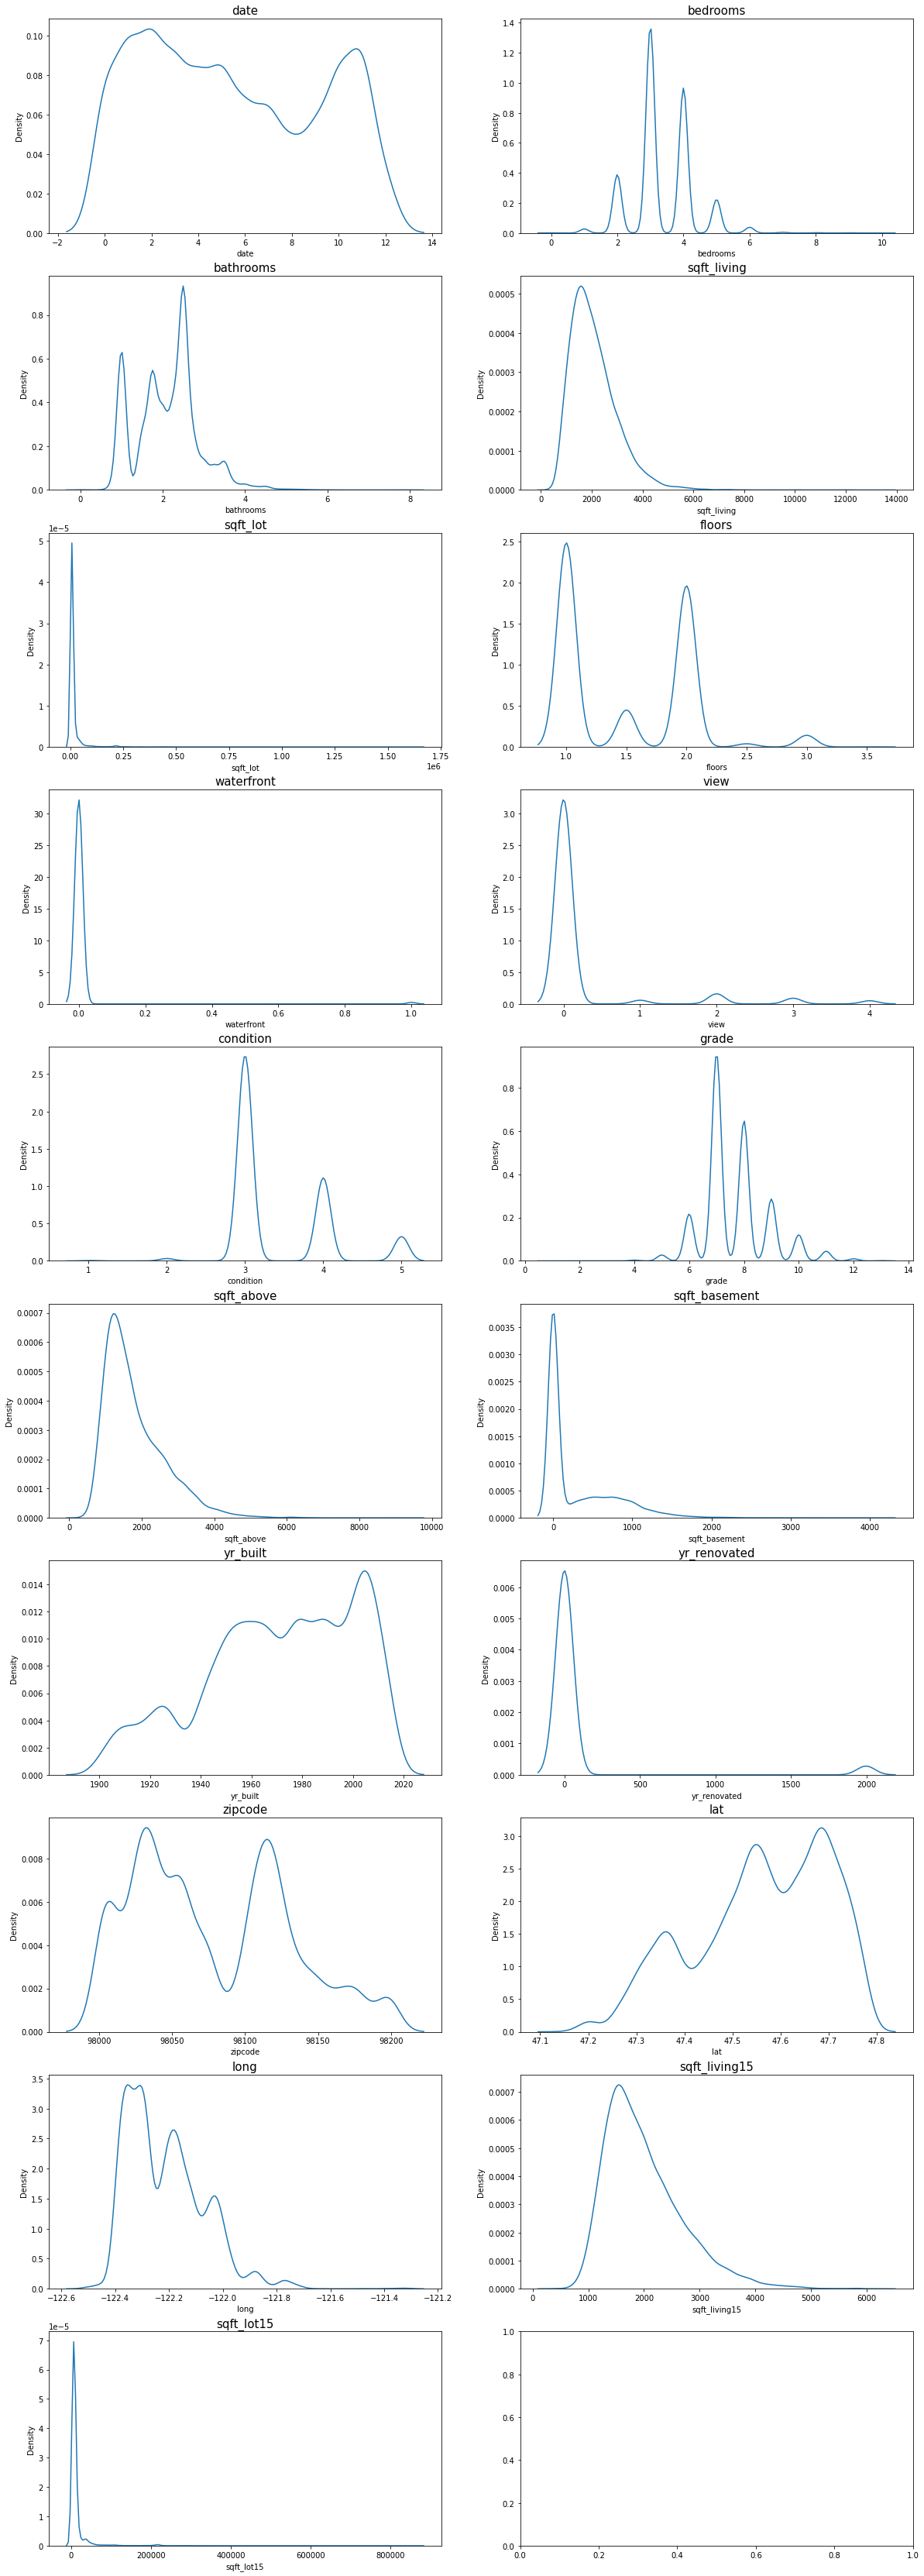

In [7]:
fig, ax = plt.subplots(10, 2, figsize=(20, 60))

# id 변수는 제외하고 분포를 확인합니다.
count = 0
columns = data.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break

In [8]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

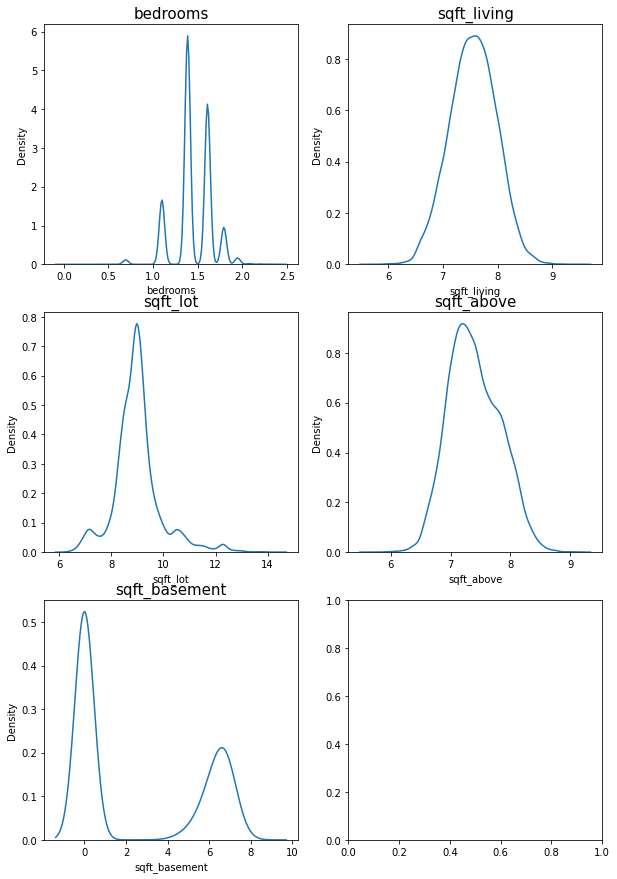

In [9]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1

In [60]:
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

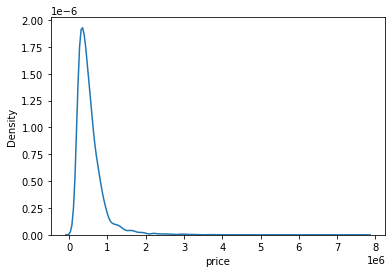

In [11]:
sns.kdeplot(y)
plt.show()

In [12]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

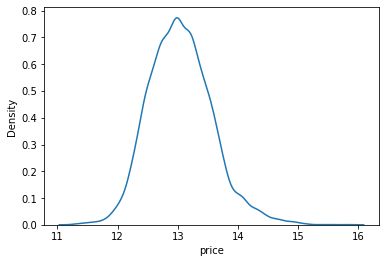

In [13]:
sns.kdeplot(y)
plt.show()

## 함수로 만들어 쓰자

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [4]:
# price에 x:->log(1+x) 를 했으므로 그 역변환 후 rmse를 구해야 원하는 메트릭이 나온다

def rmse(y_test, y_pred): # 로그가 취해진 값
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [5]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [6]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2021        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [44]:
# 모델 클래스명을 구할 수 있다
xgboost.__class__.__name__

'XGBRegressor'

In [7]:
# 과정 하나씩 표시
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(data, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

NameError: name 'data' is not defined

### get_scores 함수 

In [7]:
def get_scores(models, train, y):
    df = {}

    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

        # 모델 학습
        model.fit(X_train, y_train)

        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)

        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

# get_scores(models, train, y)

GridSearch

In [8]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

# model = LGBMRegressor(random_state=random_state)

In [22]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(data, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    1.9s finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2021), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [23]:
# 결과는 grid_model.cv_results_에 저장됨
# params와 score가 중요하다
grid_model.cv_results_
print(type(grid_model.cv_results_))

<class 'dict'>


### GridSearch 함수

In [9]:
def my_GridSearch(model, data, y, param_grid, verbose=2, n_jobs=5):
    """
    다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현해 보세요.

    1. GridSearchCV 모델로 `model`을 초기화합니다.
    2. 모델을 fitting 합니다.
    3. params, score에 각 조합에 대한 결과를 저장합니다. 
    4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
    """
    model = LGBMRegressor(random_state=random_state)
    grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=verbose, n_jobs=n_jobs)

    grid_model.fit(data, y)
    column_list = ['params', 'mean_test_score']
    params, score = tuple(map(grid_model.cv_results_.get, column_list))
    results = pd.DataFrame(params)
    results['score'] = score
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    
    results = results.sort_values(['RMSLE'])
    return results

examples and submission

In [25]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, data, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    1.0s finished


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027024,0.164389
2,10,50,-0.029173,0.170802
1,1,100,-0.055023,0.234570
0,1,50,-0.073398,0.270920


In [26]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(data, y)
prediction = model.predict(sub)
len(prediction)

6468

In [27]:
prediction = np.expm1(prediction)
len(prediction)

6468

In [28]:
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      6468 non-null   int64
 1   price   6468 non-null   int64
dtypes: int64(2)
memory usage: 101.2 KB


In [29]:
submission['price'] = prediction #????
submission.head()

,id,price
0,15035,7.718714e+05
1,15036,8.010050e+05
2,15037,1.669400e+06
3,15038,5.476823e+05
4,15039,5.963883e+05


In [10]:
def save_submission(model, data, y, sub, model_name, rmsle):
	model.fit(data, y)
	prediction = model.predict(sub)
	prediction = np.expm1(prediction)
	submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
	submission.to_csv(submission_csv_path, index=False)
	print(submission_csv_path)

In [31]:
save_submission(model, data, y, sub, 'lgbm', rmsle='0.168')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
~/aiffel/000Projects/EX6/data/data/submission_lgbm_RMSLE_0.0168.csv


## EDA

하이퍼파라미터 서치 전, 데이터를 잘 조합하여 의미있는 feature를 추출하는 것이 매우 중요합니다

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int8   
 1   bedrooms       15035 non-null  float64
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  float64
 4   sqft_lot       15035 non-null  float64
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  float64
 11  sqft_basement  15035 non-null  float64
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

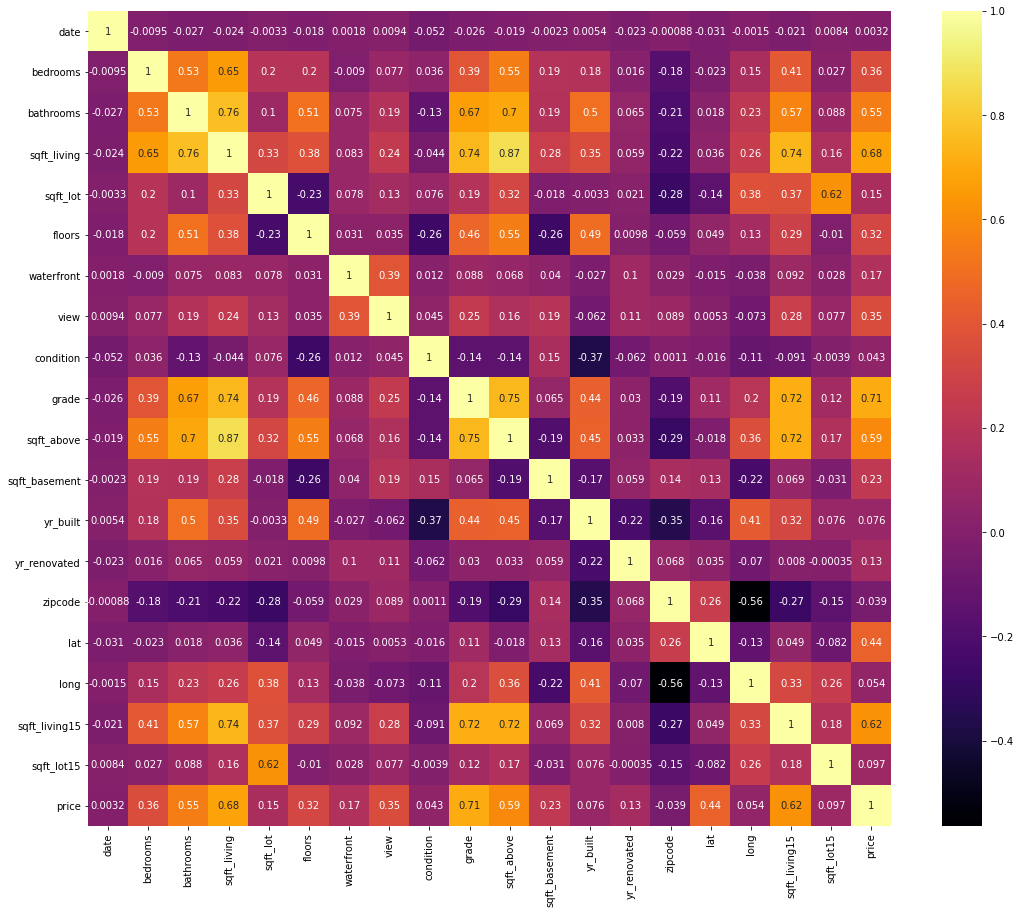

In [33]:
import seaborn as sns

data_corr = data.copy()
data_corr['price'] = y
plt.figure(figsize=(18,15))
cor = data_corr.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.inferno)
plt.show()

In [34]:
cor['price'].sort_values(ascending=False)

price            1.000000
grade            0.707412
sqft_living      0.677383
sqft_living15    0.621800
sqft_above       0.591185
bathrooms        0.552000
lat              0.444417
bedrooms         0.356086
view             0.347506
floors           0.317810
sqft_basement    0.231982
waterfront       0.172580
sqft_lot         0.145465
yr_renovated     0.127533
sqft_lot15       0.096976
yr_built         0.076293
long             0.054362
condition        0.042947
date             0.003247
zipcode         -0.039195
Name: price, dtype: float64

필요 없어 보이는 feature를 제거하기 전에, 제거해도 될지 판단하기 위해 살펴봅니다.

### waterfront & view

In [35]:
# 약 0.7%의 집이 WATERFRONT==1이다
data['waterfront'].describe(percentiles=[0.993])

count    15035.000000
mean         0.007117
std          0.084063
min          0.000000
50%          0.000000
99.3%        1.000000
max          1.000000
Name: waterfront, dtype: float64

In [36]:
data['view'].describe(percentiles=[0.90, 0.91])

count    15035.000000
mean         0.234253
std          0.763376
min          0.000000
50%          0.000000
90%          0.000000
91%          1.000000
max          4.000000
Name: view, dtype: float64

In [37]:
data[data['waterfront']==1]['view'].describe(percentiles=[0.19])

count    107.000000
mean       3.747664
std        0.584282
min        1.000000
19%        4.000000
50%        4.000000
max        4.000000
Name: view, dtype: float64

#### view 와 waterfront의 경우, waterfront==True인 데이터 포인트는 전체의 0.7% 였고, 그 중 80%는 view가 4점으로, view에 이미 waterfront의 정보가 들어있다고 볼 수 있습니다. waterfront==True 인 데이터 포인트 중 view가 4점이 아닌 경우도 살펴보겠습니다

In [38]:
waterfront_data = data_corr[data_corr['waterfront']==1]
not_so_good = waterfront_data[waterfront_data['view']!=4]

In [39]:
not_so_good.describe()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.0,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000,20.000000,20.00000,20.000000
mean,3.850000,1.364892,2.537500,7.838203,10.320425,1.725000,1.0,2.650000,3.750000,8.350000,7.683544,3.592572,1950.000000,595.950000,98082.900000,47.482845,-122.36045,2534.000000,34364.15000,13.784973
std,3.731445,0.211633,0.997612,0.577675,1.224147,0.595487,0.0,0.587143,0.850696,1.565248,0.585291,3.363270,28.749371,934.001154,46.853523,0.110399,0.13719,920.385503,30178.81919,0.781431
min,0.000000,1.098612,0.750000,6.722630,7.477604,1.000000,1.0,1.000000,2.000000,6.000000,6.329721,0.000000,1916.000000,0.000000,98004.000000,47.335100,-122.51400,750.000000,3444.00000,12.736704
25%,1.000000,1.098612,2.125000,7.542333,10.096791,1.375000,1.0,2.000000,3.000000,7.000000,7.429005,0.000000,1923.000000,0.000000,98070.000000,47.399475,-122.44825,2000.000000,17012.50000,13.353381
50%,3.000000,1.386294,2.500000,7.924881,10.269929,1.750000,1.0,3.000000,4.000000,8.000000,7.671228,5.718351,1947.000000,0.000000,98070.000000,47.453950,-122.41800,2350.000000,23718.50000,13.676976
75%,6.000000,1.442080,3.062500,8.119863,10.765405,2.000000,1.0,3.000000,4.000000,9.250000,8.024763,6.617275,1972.500000,1968.500000,98082.500000,47.568400,-122.26900,2915.000000,42123.00000,14.206029
max,12.000000,1.791759,4.500000,9.214432,13.132644,3.000000,1.0,3.000000,5.000000,11.000000,8.946505,7.766841,2006.000000,2001.000000,98199.000000,47.669900,-122.06000,4140.000000,127195.00000,15.770310


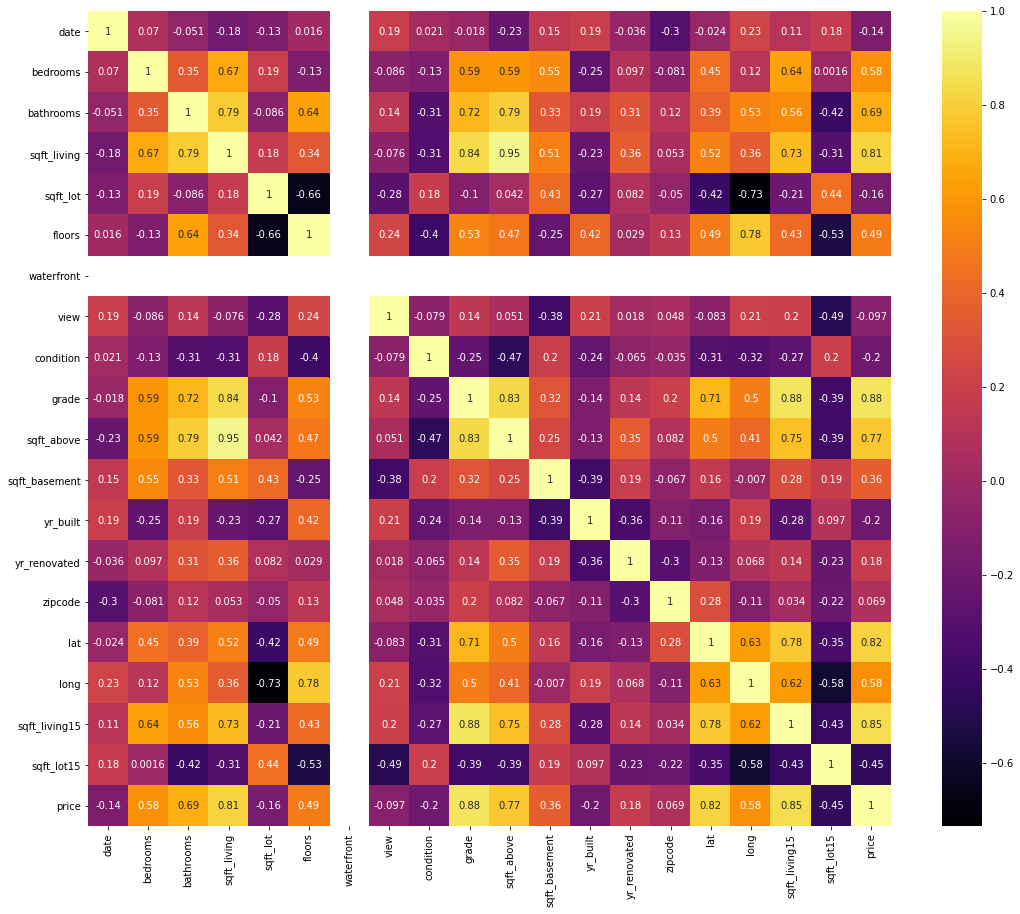

In [40]:
plt.figure(figsize=(18,15))
cor = not_so_good.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.inferno)
plt.show()

상관계수가 높은 다른 feature가 많아 삭제할 수 있을 것 같습니다. 
waterfront를 삭제합니다

In [41]:
del data['waterfront']

### sqft_basement

In [42]:
data['sqft_basement'].describe(percentiles=[0.55, 0.60, 0.65, 0.70])

count    15035.000000
mean         2.521873
std          3.166771
min          0.000000
50%          0.000000
55%          0.000000
60%          0.000000
65%          5.638355
70%          6.042633
max          8.326275
Name: sqft_basement, dtype: float64

약 60%의 값이 0임을 알 수 있습니다. 0이 아닌 값들의 분포를 살펴보겠습니다

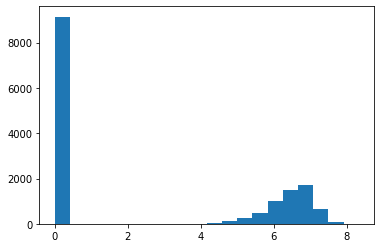

In [43]:
plt.hist(data['sqft_basement'], bins=20)
plt.show()

basement가 0이 아닌 데이터 포인트를 모아 is_basement로 저장합니다

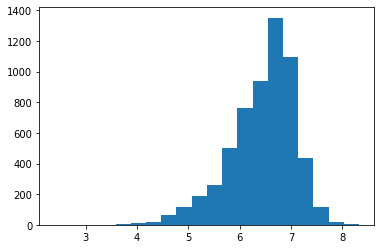

In [44]:
is_basement = data_corr[data_corr['sqft_basement']>0]
plt.hist(is_basement['sqft_basement'], bins=20)
plt.show()

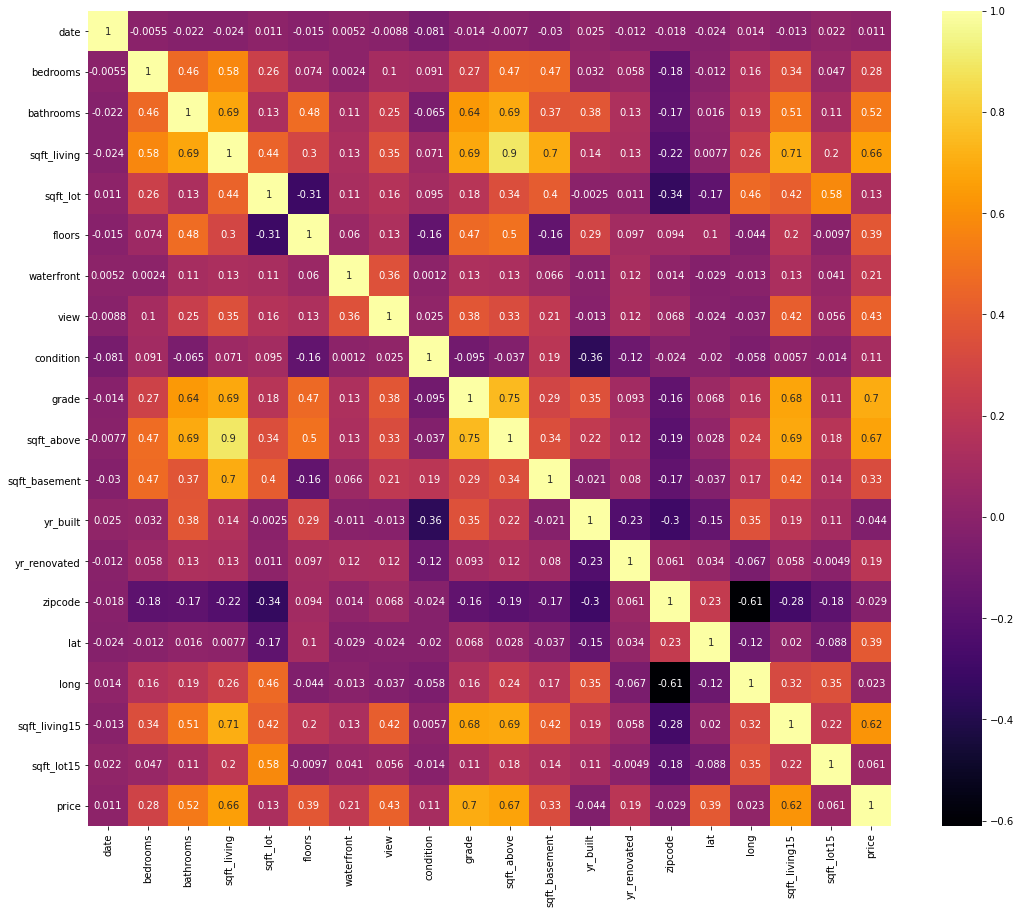

In [45]:
plt.figure(figsize=(18,15))
cor = is_basement.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.inferno)
plt.show()

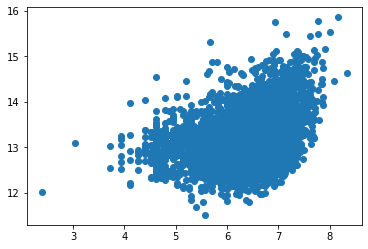

In [46]:
plt.scatter(is_basement['sqft_basement'], is_basement['price'])

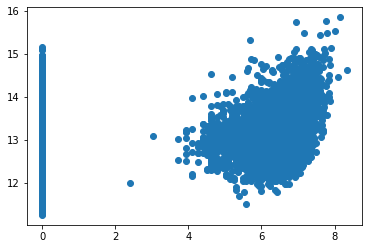

In [47]:
plt.scatter(data_corr['sqft_basement'], data_corr['price'])

sqft_basement는 price와 선형성이 별로 없는 것처럼 보입니다. 또한 sqft_living과의 상관계수가 커 sqft_living으로부터 유추가 가능하고, sqrt_basement가 0인 경우와 아닌 경우를 나누었을 때, 다른 feature의 price와의 선형성이 강화되었으므로 sqrt_basement를 0, 1의 Boolean으로 변경합니다.

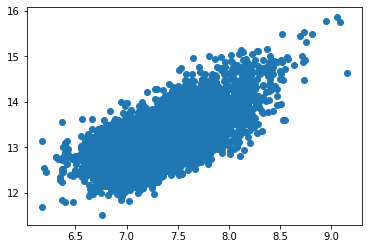

In [48]:
plt.scatter(is_basement['sqft_above'], is_basement['price'])  # 지하실이 있는 경우

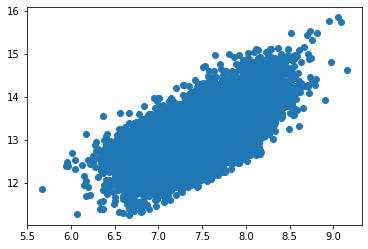

In [49]:
plt.scatter(data_corr['sqft_above'], data_corr['price'])  # 모든 경우

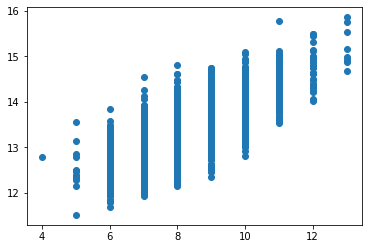

In [50]:
plt.scatter(is_basement['grade'], is_basement['price'])  # 지하실이 있는 경우

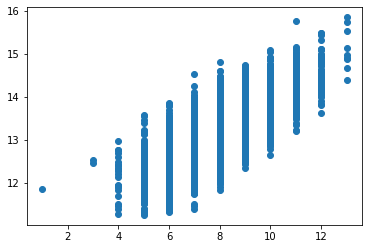

In [51]:
plt.scatter(data_corr['grade'], data_corr['price'])  # 모든 경우

In [52]:
data['sqft_basement'] = np.where(data['sqft_basement'], 1,0)

In [53]:
data['sqft_basement'].describe()

count    15035.000000
mean         0.391886
std          0.488188
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: sqft_basement, dtype: float64

Boolean으로 변경했으므로, basement로 수정합니다

In [54]:
data.rename(index=str, columns={'sqft_basement': 'basement'}, inplace=True)

In [55]:
data

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,5,1.386294,1.00,7.074117,8.639588,1.0,0,3,7,7.074117,0,1955,0,98178,47.5112,-122.257,1340,5650
1,9,1.098612,1.00,6.647688,9.210440,1.0,0,3,6,6.647688,0,1933,0,98028,47.7379,-122.233,2720,8062
2,9,1.386294,2.00,7.427144,8.997271,1.0,0,3,8,7.427144,0,1987,0,98074,47.6168,-122.045,1800,7503
3,1,1.386294,2.25,7.447751,8.827615,2.0,0,3,7,7.447751,0,1995,0,98003,47.3097,-122.327,2238,6819
4,8,1.386294,1.50,6.966967,9.181118,1.0,0,3,7,6.966967,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,5,1.609438,2.50,7.832411,8.703507,2.0,0,3,9,7.832411,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,10,1.609438,3.50,8.163656,8.881975,2.0,0,3,9,7.863651,1,2009,0,98136,47.5537,-122.398,2050,6200
15032,0,1.386294,2.50,7.333676,7.031741,3.0,0,3,8,7.333676,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,9,1.609438,2.50,7.745436,8.668024,2.0,0,3,8,7.745436,0,2014,0,98146,47.5107,-122.362,1830,7200


In [56]:
data_copy = data.copy()
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15035 entries, 0 to 15034
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int8   
 1   bedrooms       15035 non-null  float64
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  float64
 4   sqft_lot       15035 non-null  float64
 5   floors         15035 non-null  float64
 6   view           15035 non-null  int64  
 7   condition      15035 non-null  int64  
 8   grade          15035 non-null  int64  
 9   sqft_above     15035 non-null  float64
 10  basement       15035 non-null  int64  
 11  yr_built       15035 non-null  int64  
 12  yr_renovated   15035 non-null  int64  
 13  zipcode        15035 non-null  int64  
 14  lat            15035 non-null  float64
 15  long           15035 non-null  float64
 16  sqft_living15  15035 non-null  int64  
 17  sqft_lot15     15035 non-null  int64  
dtypes: float64(

In [57]:
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

In [58]:
data_copy['price'] = y.values

In [59]:
data_copy

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,5,1.386294,1.00,7.074117,8.639588,1.0,0,3,7,7.074117,0,1955,0,98178,47.5112,-122.257,1340,5650,12.309987
1,9,1.098612,1.00,6.647688,9.210440,1.0,0,3,6,6.647688,0,1933,0,98028,47.7379,-122.233,2720,8062,12.100718
2,9,1.386294,2.00,7.427144,8.997271,1.0,0,3,8,7.427144,0,1987,0,98074,47.6168,-122.045,1800,7503,13.142168
3,1,1.386294,2.25,7.447751,8.827615,2.0,0,3,7,7.447751,0,1995,0,98003,47.3097,-122.327,2238,6819,12.458779
4,8,1.386294,1.50,6.966967,9.181118,1.0,0,3,7,6.966967,0,1963,0,98198,47.4095,-122.315,1650,9711,12.583999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,5,1.609438,2.50,7.832411,8.703507,2.0,0,3,9,7.832411,0,2014,0,98056,47.5137,-122.167,2520,6023,13.322338
15031,10,1.609438,3.50,8.163656,8.881975,2.0,0,3,9,7.863651,1,2009,0,98136,47.5537,-122.398,2050,6200,13.822984
15032,0,1.386294,2.50,7.333676,7.031741,3.0,0,3,8,7.333676,0,2009,0,98103,47.6993,-122.346,1530,1509,12.793862
15033,9,1.609438,2.50,7.745436,8.668024,2.0,0,3,8,7.745436,0,2014,0,98146,47.5107,-122.362,1830,7200,12.899222


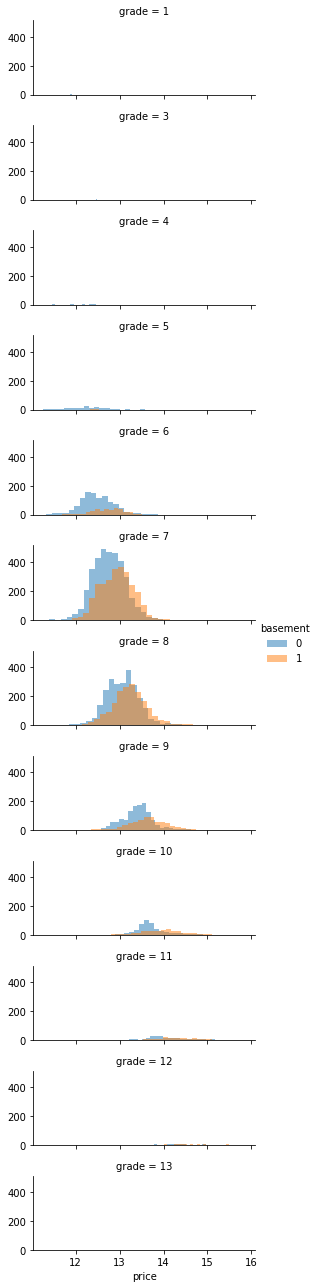

In [60]:
grid = sns.FacetGrid(data_copy, row='grade', hue='basement', height=1.5, aspect=2.5)  # 수정
grid.map(plt.hist, 'price', alpha=.5, bins=20)
grid.add_legend()

### yr_renovated

In [61]:
data['yr_renovated'].describe()

count    15035.000000
mean        83.798936
std        400.398498
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2015.000000
Name: yr_renovated, dtype: float64

yr_renovated 역시 대다수의 경우 0 입니다. 0이 아닌 경우를 살펴보겠습니다
또한 재건축되지 않은 경우의 yr_built와 price의 관계도 보겠습니다

In [62]:
renovated = data_copy[data_copy['yr_renovated']!=0]

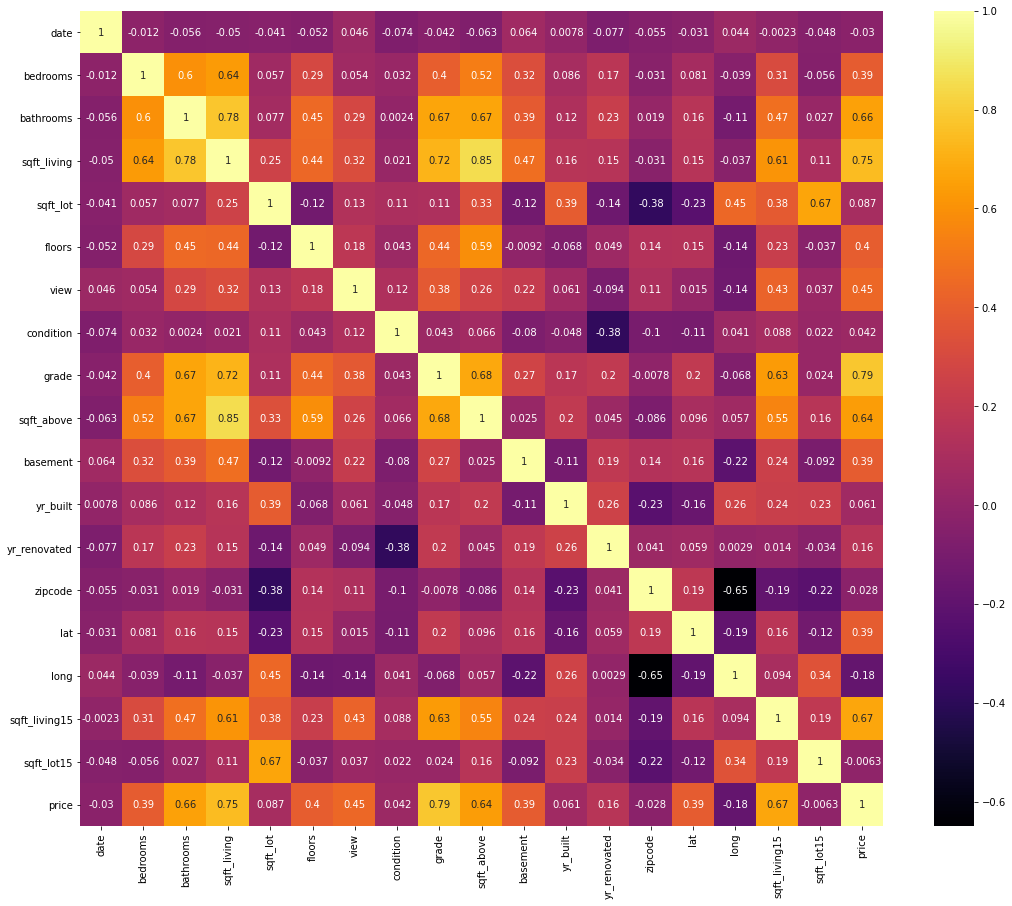

In [63]:
plt.figure(figsize=(18,15))
cor = renovated.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.inferno)
plt.show()

In [64]:
not_renovated = data_copy[data_copy['yr_renovated']==0]

In [65]:
not_renovated

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,5,1.386294,1.00,7.074117,8.639588,1.0,0,3,7,7.074117,0,1955,0,98178,47.5112,-122.257,1340,5650,12.309987
1,9,1.098612,1.00,6.647688,9.210440,1.0,0,3,6,6.647688,0,1933,0,98028,47.7379,-122.233,2720,8062,12.100718
2,9,1.386294,2.00,7.427144,8.997271,1.0,0,3,8,7.427144,0,1987,0,98074,47.6168,-122.045,1800,7503,13.142168
3,1,1.386294,2.25,7.447751,8.827615,2.0,0,3,7,7.447751,0,1995,0,98003,47.3097,-122.327,2238,6819,12.458779
4,8,1.386294,1.50,6.966967,9.181118,1.0,0,3,7,6.966967,0,1963,0,98198,47.4095,-122.315,1650,9711,12.583999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,5,1.609438,2.50,7.832411,8.703507,2.0,0,3,9,7.832411,0,2014,0,98056,47.5137,-122.167,2520,6023,13.322338
15031,10,1.609438,3.50,8.163656,8.881975,2.0,0,3,9,7.863651,1,2009,0,98136,47.5537,-122.398,2050,6200,13.822984
15032,0,1.386294,2.50,7.333676,7.031741,3.0,0,3,8,7.333676,0,2009,0,98103,47.6993,-122.346,1530,1509,12.793862
15033,9,1.609438,2.50,7.745436,8.668024,2.0,0,3,8,7.745436,0,2014,0,98146,47.5107,-122.362,1830,7200,12.899222


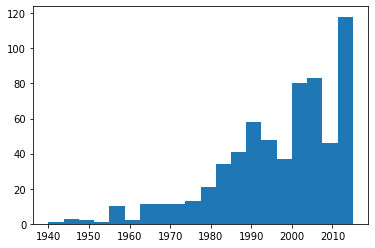

In [66]:
plt.hist(renovated['yr_renovated'], bins=20)
plt.show()

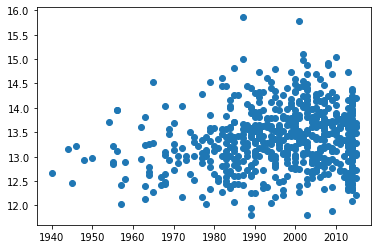

In [67]:
plt.scatter(renovated['yr_renovated'], renovated['price'])  # 재건축 한 경우 그 연도와 가격

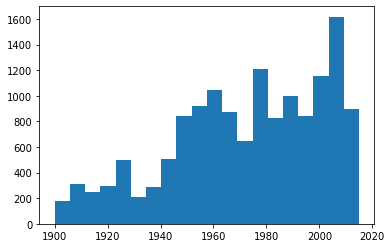

In [68]:
plt.hist(not_renovated['yr_built'], bins=20)
plt.show()

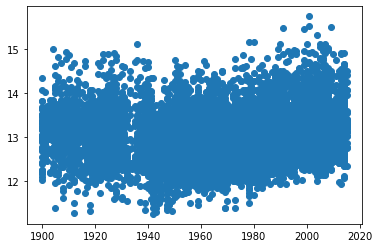

In [69]:
plt.scatter(not_renovated['yr_built'], not_renovated['price'])  # 모든 경우

6개의 구간을 지닌 yearband로 나누어 봅니다

In [70]:
# 6개의 구간으로 분류  [0, 5]
data_copy['yearband'] = pd.cut(data_copy['yr_built'], 6) 

# 구간 보여주기
data_copy[['yearband', 'price']].groupby(['yearband'], as_index=False).mean().sort_values(by='yearband', ascending=True)

,yearband,price
0,"(1899.885, 1919.167]",13.171488
1,"(1919.167, 1938.333]",13.146960
2,"(1938.333, 1957.5]",12.905727
3,"(1957.5, 1976.667]",12.918169
4,"(1976.667, 1995.833]",13.042210
5,"(1995.833, 2015.0]",13.187339


재건축을 했다면 year_built를 재건축 연도(year_renovated)가 속하는 yearband로 하고, 그렇지 않은 경우 year_built가 속하는 yearband로 변환합니다

In [71]:
# year_built를 ordinal 데이터로 변경
for dataset in [data_copy]:
    dataset.loc[ dataset['yr_built'] <= 1919.167, 'yr_built'] = 0
    dataset.loc[(dataset['yr_built'] > 1919.167) & (dataset['yr_built'] <= 1938.333), 'yr_built'] = 1
    dataset.loc[(dataset['yr_built'] > 1938.333) & (dataset['yr_built'] <= 1957.5), 'yr_built'] = 2
    dataset.loc[(dataset['yr_built'] > 1957.5) & (dataset['yr_built'] <= 1976.667), 'yr_built'] = 3
    dataset.loc[(dataset['yr_built'] > 1976.667) & (dataset['yr_built'] <= 1995.833), 'yr_built'] = 4
    dataset.loc[ dataset['yr_built'] > 1995.833, 'yr_built'] = 5
data_copy.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,yearband
0,5,1.386294,1.00,7.074117,8.639588,1.0,0,3,7,7.074117,0,2,0,98178,47.5112,-122.257,1340,5650,12.309987,"(1938.333, 1957.5]"
1,9,1.098612,1.00,6.647688,9.210440,1.0,0,3,6,6.647688,0,1,0,98028,47.7379,-122.233,2720,8062,12.100718,"(1919.167, 1938.333]"
2,9,1.386294,2.00,7.427144,8.997271,1.0,0,3,8,7.427144,0,4,0,98074,47.6168,-122.045,1800,7503,13.142168,"(1976.667, 1995.833]"
3,1,1.386294,2.25,7.447751,8.827615,2.0,0,3,7,7.447751,0,4,0,98003,47.3097,-122.327,2238,6819,12.458779,"(1976.667, 1995.833]"
4,8,1.386294,1.50,6.966967,9.181118,1.0,0,3,7,6.966967,0,3,0,98198,47.4095,-122.315,1650,9711,12.583999,"(1957.5, 1976.667]"


In [72]:
data_copy[data_copy['yr_renovated']>0][['yr_built', 'yr_renovated', 'yearband']].head(10)

,yr_built,yr_renovated,yearband
26,1,2002,"(1919.167, 1938.333]"
78,0,1999,"(1899.885, 1919.167]"
149,2,1991,"(1938.333, 1957.5]"
160,0,1978,"(1899.885, 1919.167]"
166,0,2005,"(1899.885, 1919.167]"
191,4,2008,"(1976.667, 1995.833]"
194,2,2003,"(1938.333, 1957.5]"
199,0,1994,"(1899.885, 1919.167]"
227,1,1984,"(1919.167, 1938.333]"
254,1,1954,"(1919.167, 1938.333]"


In [73]:
for dataset in [data_copy]:
    dataset.loc[(dataset['yr_renovated'] > 0) &  (dataset['yr_renovated'] <= 1919.167), 'yr_built'] = 0
    dataset.loc[(dataset['yr_renovated'] > 1919.167) & (dataset['yr_renovated'] <= 1938.333), 'yr_built'] = 1
    dataset.loc[(dataset['yr_renovated'] > 1938.333) & (dataset['yr_renovated'] <= 1957.5), 'yr_built'] = 2
    dataset.loc[(dataset['yr_renovated'] > 1957.5) & (dataset['yr_renovated'] <= 1976.667), 'yr_built'] = 3
    dataset.loc[(dataset['yr_renovated'] > 1976.667) & (dataset['yr_renovated'] <= 1995.833), 'yr_built'] = 4
    dataset.loc[ dataset['yr_renovated'] > 1995.833, 'yr_built'] = 5
data_copy.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,yearband
0,5,1.386294,1.00,7.074117,8.639588,1.0,0,3,7,7.074117,0,2,0,98178,47.5112,-122.257,1340,5650,12.309987,"(1938.333, 1957.5]"
1,9,1.098612,1.00,6.647688,9.210440,1.0,0,3,6,6.647688,0,1,0,98028,47.7379,-122.233,2720,8062,12.100718,"(1919.167, 1938.333]"
2,9,1.386294,2.00,7.427144,8.997271,1.0,0,3,8,7.427144,0,4,0,98074,47.6168,-122.045,1800,7503,13.142168,"(1976.667, 1995.833]"
3,1,1.386294,2.25,7.447751,8.827615,2.0,0,3,7,7.447751,0,4,0,98003,47.3097,-122.327,2238,6819,12.458779,"(1976.667, 1995.833]"
4,8,1.386294,1.50,6.966967,9.181118,1.0,0,3,7,6.966967,0,3,0,98198,47.4095,-122.315,1650,9711,12.583999,"(1957.5, 1976.667]"


In [74]:
data_copy[data_copy['yr_renovated']>0][['yr_built', 'yr_renovated']].head(10)

,yr_built,yr_renovated
26,5,2002
78,5,1999
149,4,1991
160,4,1978
166,5,2005
191,5,2008
194,5,2003
199,4,1994
227,4,1984
254,2,1954


변환되었다. yearband는 삭제한다.

In [75]:
del data_copy['yearband']

In [76]:
data_copy['yr_renovated'] = np.where(data_copy['yr_renovated'], 1,0)

In [77]:
data_copy.rename(index=str, columns={'yr_renovated': 'renovated'}, inplace=True)

## zipcode

In [78]:
data['latlong'] = data['lat'].map(str) + ',' + data['long'].map(str)
data['latlong'][0]

'47.5112,-122.257'

In [79]:
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,latlong
0,5,1.386294,1.00,7.074117,8.639588,1.0,0,3,7,7.074117,0,1955,0,98178,47.5112,-122.257,1340,5650,"47.5112,-122.257"
1,9,1.098612,1.00,6.647688,9.210440,1.0,0,3,6,6.647688,0,1933,0,98028,47.7379,-122.233,2720,8062,"47.7379,-122.233"
2,9,1.386294,2.00,7.427144,8.997271,1.0,0,3,8,7.427144,0,1987,0,98074,47.6168,-122.045,1800,7503,"47.6168,-122.045"
3,1,1.386294,2.25,7.447751,8.827615,2.0,0,3,7,7.447751,0,1995,0,98003,47.3097,-122.327,2238,6819,"47.3097,-122.327"
4,8,1.386294,1.50,6.966967,9.181118,1.0,0,3,7,6.966967,0,1963,0,98198,47.4095,-122.315,1650,9711,"47.4095,-122.315"


In [80]:
sub['latlong'] = sub['lat'].map(str) + ',' + sub['long'].map(str)
sub['latlong'][0]

'47.721,-122.319'

In [11]:
!pip install geocoder ipython-autotime geopy geopandas plotly_express

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [11]:
%load_ext autotime
import pandas as pd
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
import plotly_express as px
import tqdm
from tqdm._tqdm_notebook import tqdm_notebook

time: 359 ms (started: 2021-08-09 09:02:32 +00:00)


In [83]:
locator = Nominatim(user_agent="myGeocoder", timeout=300)
rgeocode = RateLimiter(locator.reverse, min_delay_seconds=0.0001)

time: 1.06 ms (started: 2021-08-08 10:10:05 +00:00)


In [84]:
small = data[:10]

time: 56.4 ms (started: 2021-08-08 10:10:05 +00:00)


In [85]:
small.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,latlong
0,5,1.386294,1.00,7.074117,8.639588,1.0,0,3,7,7.074117,0,1955,0,98178,47.5112,-122.257,1340,5650,"47.5112,-122.257"
1,9,1.098612,1.00,6.647688,9.210440,1.0,0,3,6,6.647688,0,1933,0,98028,47.7379,-122.233,2720,8062,"47.7379,-122.233"
2,9,1.386294,2.00,7.427144,8.997271,1.0,0,3,8,7.427144,0,1987,0,98074,47.6168,-122.045,1800,7503,"47.6168,-122.045"
3,1,1.386294,2.25,7.447751,8.827615,2.0,0,3,7,7.447751,0,1995,0,98003,47.3097,-122.327,2238,6819,"47.3097,-122.327"
4,8,1.386294,1.50,6.966967,9.181118,1.0,0,3,7,6.966967,0,1963,0,98198,47.4095,-122.315,1650,9711,"47.4095,-122.315"


time: 71.2 ms (started: 2021-08-08 10:10:05 +00:00)


In [86]:
tqdm_notebook.pandas()
small['city'] = small['latlong'].progress_apply(rgeocode)
small.head()

  0%|          | 0/10 [00:00<?, ?it/s]

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,latlong,city
0,5,1.386294,1.00,7.074117,8.639588,1.0,0,3,7,7.074117,0,1955,0,98178,47.5112,-122.257,1340,5650,"47.5112,-122.257","(10012, 61st Avenue South, Rainier Beach, Seat..."
1,9,1.098612,1.00,6.647688,9.210440,1.0,0,3,6,6.647688,0,1933,0,98028,47.7379,-122.233,2720,8062,"47.7379,-122.233","(15109, 81st Avenue Northeast, Moorlands, Kenm..."
2,9,1.386294,2.00,7.427144,8.997271,1.0,0,3,8,7.427144,0,1987,0,98074,47.6168,-122.045,1800,7503,"47.6168,-122.045","(923, 221st Avenue Northeast, Sammamish, King ..."
3,1,1.386294,2.25,7.447751,8.827615,2.0,0,3,7,7.447751,0,1995,0,98003,47.3097,-122.327,2238,6819,"47.3097,-122.327","(533, South 330th Place, Federal Way, King Cou..."
4,8,1.386294,1.50,6.966967,9.181118,1.0,0,3,7,6.966967,0,1963,0,98198,47.4095,-122.315,1650,9711,"47.4095,-122.315","(21421, 14th Avenue South, Des Moines Creek, D..."


time: 4.96 s (started: 2021-08-08 10:10:05 +00:00)


In [87]:
item = small['city'][0].raw['address']['city']

time: 527 µs (started: 2021-08-08 10:10:10 +00:00)


In [88]:
item

'Seattle'

time: 46.2 ms (started: 2021-08-08 10:10:10 +00:00)


In [89]:
tqdm_notebook.pandas()
#data_address= data['latlong'].progress_apply(rgeocode)

time: 42.1 ms (started: 2021-08-08 10:10:10 +00:00)


In [90]:
tqdm_notebook.pandas()
#sub_address = sub['latlong'].progress_apply(rgeocode)
#sub_address

time: 44.7 ms (started: 2021-08-08 10:10:10 +00:00)


In [91]:
# data['address'] = data_address

time: 43.5 ms (started: 2021-08-08 10:10:10 +00:00)


In [92]:
# data_address_full = data['address']
# data_address_full.to_pickle("full_address.pkl")

time: 54.9 ms (started: 2021-08-08 10:10:10 +00:00)


In [93]:
#sub['address'] = sub_address
#sub['address'].to_pickle('sub_address.pkl')

time: 42.6 ms (started: 2021-08-08 10:10:10 +00:00)


In [95]:
address = pd.read_pickle("full_address.pkl")
sub_address = pd.read_pickle('sub_address.pkl')

time: 443 ms (started: 2021-08-08 10:10:22 +00:00)


In [96]:
address

0        (10012, 61st Avenue South, Rainier Beach, Seat...
1        (15109, 81st Avenue Northeast, Moorlands, Kenm...
2        (923, 221st Avenue Northeast, Sammamish, King ...
3        (533, South 330th Place, Federal Way, King Cou...
4        (21421, 14th Avenue South, Des Moines Creek, D...
                               ...                        
15030    (3920, Northeast 24th Court, Glencoe, Renton, ...
15031    (5408, Beach Drive Southwest, West Seattle, Se...
15032    (927, North 97th Street, Licton Springs, Green...
15033    (2211, Southwest 103rd Place, White Center, Se...
15034    (916, 26th Avenue South, Leschi, Seattle, King...
Name: address, Length: 15035, dtype: object

time: 8.2 ms (started: 2021-08-08 10:10:24 +00:00)


In [97]:
item = address[100]
item.raw['address']

{'house_number': '12703',
 'road': 'Southeast 86th Place',
 'neighbourhood': 'Olympus',
 'village': 'Newcastle',
 'county': 'King County',
 'state': 'Washington',
 'postcode': '98056',
 'country': 'United States',
 'country_code': 'us'}

time: 2.49 ms (started: 2021-08-08 10:10:25 +00:00)


In [98]:
address.to_csv("address.csv", index=False)

time: 35.9 ms (started: 2021-08-08 10:10:26 +00:00)


In [99]:
address_csv = pd.read_csv('address.csv')

time: 17.2 ms (started: 2021-08-08 10:10:26 +00:00)


In [100]:
address

0        (10012, 61st Avenue South, Rainier Beach, Seat...
1        (15109, 81st Avenue Northeast, Moorlands, Kenm...
2        (923, 221st Avenue Northeast, Sammamish, King ...
3        (533, South 330th Place, Federal Way, King Cou...
4        (21421, 14th Avenue South, Des Moines Creek, D...
                               ...                        
15030    (3920, Northeast 24th Court, Glencoe, Renton, ...
15031    (5408, Beach Drive Southwest, West Seattle, Se...
15032    (927, North 97th Street, Licton Springs, Green...
15033    (2211, Southwest 103rd Place, White Center, Se...
15034    (916, 26th Avenue South, Leschi, Seattle, King...
Name: address, Length: 15035, dtype: object

time: 5.43 ms (started: 2021-08-08 10:10:27 +00:00)


In [101]:
cities_from_csv = address_csv['address'].apply(lambda x : str(x.split(',').__getitem__(3)))
cities_from_csv

0             Seattle
1             Kenmore
2         King County
3         King County
4          Des Moines
             ...     
15030          Renton
15031         Seattle
15032       Greenwood
15033         Seattle
15034         Seattle
Name: address, Length: 15035, dtype: object

time: 14.8 ms (started: 2021-08-08 10:10:27 +00:00)


# EDA 정리

* 상관계수가 낮은 zipcode는 city로 변환한 뒤, 각 자리수의 값의 조합으로 범주화합니다.(https://www.kaggle.com/tmheo74/geo-data-eda-and-feature-engineering) date의 경우 모든 column과 상관계수가 낮은데, 부동산 가격에 영향을 미치는 대표적인 지표, 미국 10년물 국채 금리에 대응시킵니다.

* sqft_basement의 경우 price와의 상관계수가 크지 않으며 sqrt_living에서 추론할 수 있고, 0인 경우와 아닌 경우로 나누었을 때, 다른 feature의 선형성이 증가하므로, 0 혹은 1 의 boolean으로 변경합니다.

* view 와 waterfront의 경우, waterfront==True인 데이터 포인트는 전체의 0.7% 였고, 그 중 80%는 view가 4점으로, view가 waterfront의 정보를 포함하고, view가 4점이 아닌 waterfront의 경우에도, 다른 feature에서 유추할 수 있을 것 같습니다. waterfront를 삭제합니다

* 건축년도의 경우, 6개의 yearband로 나누어 ordinal 데이터를 추가합니다. 이때, 재건축되었다면, 재건축 년도 기준으로 변환합니다. 그리고 yr_renovated는 boolean으로 변경합니다 

* 여러 변수를 합쳐 파생변수를 만들어봅니다(https://www.kaggle.com/rangmar/25th-solution-xgb-lightgbm-ensemble)

In [256]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

time: 818 µs (started: 2021-08-09 12:42:49 +00:00)


In [257]:
data_dir = '~/aiffel/000Projects/EX6/data/data'


train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

data = pd.read_csv(train_data_path)
sub = pd.read_csv(test_data_path)

print('Done')

Done
time: 37.2 ms (started: 2021-08-09 12:42:49 +00:00)


In [258]:
data['date_category'] = data['date'].apply(lambda i: i[:6]).astype('category').cat.codes
sub['date_category'] = sub['date'].apply(lambda i: i[:6]).astype('category').cat.codes

data['date'] = data['date'].apply(lambda i: i[:6]).astype(int)
sub['date'] = sub['date'].apply(lambda i: i[:6]).astype(int)

del sub['id']
del data['id']

time: 18.8 ms (started: 2021-08-09 12:42:50 +00:00)


In [259]:
y = data['price']
y = np.log1p(y)
del data['price']

time: 1.56 ms (started: 2021-08-09 12:42:50 +00:00)


In [260]:
data.shape

(15035, 20)

time: 1.66 ms (started: 2021-08-09 12:42:51 +00:00)


In [261]:
sub.shape

(6468, 20)

time: 1.84 ms (started: 2021-08-09 12:42:51 +00:00)


In [262]:
combine = data, sub

time: 365 µs (started: 2021-08-09 12:42:52 +00:00)


In [263]:
bond_yield = [2.475, 2.532, 2.562, 2.345, 2.495, 2.335,
              2.173, 2.170, 1.639, 1.997, 1.927, 2.035, 2.123]  # 미국 월별 10년물 국채 금리 
bond_yield_map = {}
for idx, value in enumerate(bond_yield):
    bond_yield_map[idx] = value
    
def mapping_func(x):
    return bond_yield[x]

time: 626 µs (started: 2021-08-09 12:42:52 +00:00)


date -> yield

In [264]:
for dataset in combine:
    dataset['yield'] = dataset['date_category'].apply(mapping_func)
    del dataset['date_category']

time: 7.16 ms (started: 2021-08-09 12:42:53 +00:00)


zipcode -> city

In [265]:
def city_mapping_func(x):
    try: 
        return x.raw['address']['city']
    except KeyError:
        try:
            return x.raw['address']['town']
        except KeyError:
            return 'other'

time: 483 µs (started: 2021-08-09 12:42:54 +00:00)


In [266]:
loaded_df = pd.read_pickle("full_address.pkl")
cities = loaded_df.apply(city_mapping_func)
data['city'] = cities.values

time: 349 ms (started: 2021-08-09 12:42:54 +00:00)


In [267]:
loaded_df = pd.read_pickle("sub_address.pkl")
cities = loaded_df.apply(city_mapping_func)
sub['city'] = cities.values

time: 99.5 ms (started: 2021-08-09 12:42:55 +00:00)


In [268]:
combine = data, sub

time: 372 µs (started: 2021-08-09 12:42:56 +00:00)


In [273]:
# https://www.kaggle.com/tmheo74/geo-data-eda-and-feature-engineering
for dataset in combine:
    dataset['zipcode'] = dataset['zipcode'].apply(str).str.replace(',', '')
    dataset['zipcode-3'] = 'z_' +  dataset['zipcode'].str[2:3]
    dataset['zipcode-4'] = 'z_' +  dataset['zipcode'].str[3:4]
    dataset['zipcode-5'] = 'z_' +  dataset['zipcode'].str[4:5]
    dataset['zipcode-34'] = 'z_' + dataset['zipcode'].str[2:4]
    dataset['zipcode-45'] = 'z_' + dataset['zipcode'].str[3:5]
    dataset['zipcode-35'] = 'z_' + dataset['zipcode'].str[2:3] + dataset['zipcode'].str[4:5]

combine = data, sub

time: 63.8 ms (started: 2021-08-09 12:47:11 +00:00)


In [274]:
sub

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_living15,sqft_lot15,yield,city,zipcode-3,zipcode-4,zipcode-5,zipcode-34,zipcode-45,zipcode-35
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,...,1690,7639,2.170,Seattle,z_1,z_2,z_5,z_12,z_25,z_15
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,...,1360,5000,2.170,Seattle,z_1,z_3,z_6,z_13,z_36,z_16
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,...,4760,101930,2.475,Union Hill-Novelty Hill,z_0,z_5,z_3,z_05,z_53,z_03
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,...,1780,8113,2.035,Seattle,z_1,z_4,z_6,z_14,z_46,z_16
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,...,2390,7570,1.927,Maple Valley,z_0,z_3,z_8,z_03,z_38,z_08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,201406,3,1.75,1500,11968,1.0,0,0,3,6,...,1320,11303,2.532,other,z_0,z_1,z_0,z_01,z_10,z_00
6464,201501,3,2.00,1490,1126,3.0,0,0,3,8,...,1400,1230,1.639,Seattle,z_1,z_4,z_4,z_14,z_44,z_14
6465,201502,3,2.50,1310,1294,2.0,0,0,3,8,...,1330,1265,1.997,Seattle,z_1,z_1,z_6,z_11,z_16,z_16
6466,201406,2,0.75,1020,1350,2.0,0,0,3,7,...,1020,2007,2.532,Seattle,z_1,z_4,z_4,z_14,z_44,z_14


time: 36.8 ms (started: 2021-08-09 12:47:13 +00:00)


In [275]:
set(cities)

{'Auburn',
 'Bellevue',
 'Bothell',
 'Burien',
 'Carnation',
 'Cottage Lake',
 'Covington',
 'Des Moines',
 'Duvall',
 'Enumclaw',
 'Federal Way',
 'Issaquah',
 'Kenmore',
 'Kent',
 'King County',
 'Kirkland',
 'Lake Forest Park',
 'Maple Valley',
 'Mercer Island',
 'Mountlake Terrace',
 'North Bend',
 'Redmond',
 'Renton',
 'Riverbend',
 'Sammamish',
 'SeaTac',
 'Seattle',
 'Shoreline',
 'Snoqualmie',
 'Tanner',
 'Tukwila',
 'Union Hill-Novelty Hill',
 'Vashon',
 'Woodinville',
 'other'}

time: 4.89 ms (started: 2021-08-09 12:47:44 +00:00)


개수가 200개 미만인 city는 other로 변경합니다

In [276]:
top_cities = data['city'].value_counts()>200
top_city_list = top_cities[top_cities==True].index.to_list()

time: 5.58 ms (started: 2021-08-09 12:47:56 +00:00)


In [277]:
for dataset in combine:
    dataset['city'] = dataset['city'].apply(lambda x: x if x in top_city_list else 'other')
    dataset.rename(index=str, columns={'sqft_basement': 'basement'}, inplace=True)
    dataset['basement'] = np.where(dataset['basement'], 1, 0)
combine = data, sub

time: 17.6 ms (started: 2021-08-09 12:48:00 +00:00)


In [278]:
data['city'].value_counts()

Seattle         4968
other           2864
Renton           903
Bellevue         899
Kent             694
Kirkland         670
Sammamish        667
Auburn           548
Federal Way      524
Shoreline        430
Maple Valley     391
Redmond          381
Issaquah         374
Burien           316
Snoqualmie       205
Kenmore          201
Name: city, dtype: int64

time: 6.53 ms (started: 2021-08-09 12:48:02 +00:00)


In [279]:
sub['city'].value_counts()

Seattle         2080
other           1249
Bellevue         420
Renton           398
Kirkland         296
Sammamish        284
Auburn           278
Kent             262
Federal Way      236
Shoreline        193
Issaquah         171
Maple Valley     156
Redmond          151
Burien           128
Snoqualmie        84
Kenmore           82
Name: city, dtype: int64

time: 5.19 ms (started: 2021-08-09 12:48:03 +00:00)


In [280]:
# https://www.kaggle.com/rangmar/25th-solution-xgb-lightgbm-ensemble
    # 레벨 관련
for df in combine:
    df['sum_level'] = df['grade'] + df['view'] + df['condition'] # 등급 총합
    df['multi_level'] = df['grade'] * (df['view']+1) * df['condition']

    df['condition_2'] = df['condition'].apply(lambda x : 0 if x < 3 else x)
    df['sum_level_2'] = df['view'] + df['condition_2'] + df['grade']

    del df['condition_2']

    df['low_cond']=df['condition'].apply(lambda x : 0 if x <= 2 else 1)
    df['low_view'] = df['view'].apply(lambda x : 0 if x == 0 else 1)
    df['low_bath'] = df['bathrooms'].apply(lambda x: 0 if x < 1 else 1)
    df['low_bed'] = df['bedrooms'].apply(lambda x : 0 if x ==1 else 1)
    df['low_grade'] = df['grade'].apply(lambda x : 0 if x <= 6 else 1)
    df['low_all'] = (df['low_cond'] + df['low_view']+df['low_bath'] + df['low_bed'] + df['low_grade']) + df['waterfront']

    del df['low_cond'], df['low_view'], df['low_bath'], df['low_bed'], df['low_grade']
    
combine = data, sub

time: 62.1 ms (started: 2021-08-09 12:48:06 +00:00)


In [281]:
for dataset in combine:
    pass
    # del dataset['waterfront']  # 0.7% 만 존재
combine = data, sub

time: 436 µs (started: 2021-08-09 12:48:08 +00:00)


In [282]:
data.head(30)

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,zipcode-3,zipcode-4,zipcode-5,zipcode-34,zipcode-45,zipcode-35,sum_level,multi_level,sum_level_2,low_all
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,...,z_1,z_7,z_8,z_17,z_78,z_18,10,21,10,4
1,201502,2,1.00,770,10000,1.0,0,0,3,6,...,z_0,z_2,z_8,z_02,z_28,z_08,9,18,9,3
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,...,z_0,z_7,z_4,z_07,z_74,z_04,11,24,11,4
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,...,z_0,z_0,z_3,z_00,z_03,z_03,10,21,10,4
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,...,z_1,z_9,z_8,z_19,z_98,z_18,10,21,10,4
5,201504,3,2.50,3560,9796,1.0,0,0,3,8,...,z_0,z_0,z_7,z_00,z_07,z_07,11,24,11,4
6,201405,2,1.00,1160,6000,1.0,0,0,4,7,...,z_1,z_1,z_5,z_11,z_15,z_15,11,28,11,4
7,201405,3,1.00,1430,19901,1.5,0,0,4,7,...,z_0,z_2,z_8,z_02,z_28,z_08,11,28,11,4
8,201410,3,1.75,1370,9680,1.0,0,0,4,7,...,z_0,z_7,z_4,z_07,z_74,z_04,11,28,11,4
9,201503,5,2.00,1810,4850,1.5,0,0,3,7,...,z_1,z_0,z_7,z_10,z_07,z_17,10,21,10,4


time: 34.4 ms (started: 2021-08-09 12:48:09 +00:00)


In [283]:
# 6개의 구간으로 분류  [0, 5]
data['yearband'] = pd.cut(data['yr_built'], 6) 
data['yrband'] = data['yr_built']
# 구간 보여주기
data[['yearband', 'yr_built']].groupby(['yearband'], as_index=False).mean().sort_values(by='yearband', ascending=True)

,yearband,yr_built
0,"(1899.885, 1919.167]",1910.309073
1,"(1919.167, 1938.333]",1927.292813
2,"(1938.333, 1957.5]",1948.927438
3,"(1957.5, 1976.667]",1966.282198
4,"(1976.667, 1995.833]",1985.450951
5,"(1995.833, 2015.0]",2005.468058


time: 19.2 ms (started: 2021-08-09 12:48:20 +00:00)


In [284]:
# year_built를 ordinal 데이터로 변경
for dataset in combine:
    dataset.loc[ dataset['yr_built'] <= 1919.167, 'yrband'] = 0
    dataset.loc[(dataset['yr_built'] > 1919.167) & (dataset['yr_built'] <= 1938.333), 'yrband'] = 1
    dataset.loc[(dataset['yr_built'] > 1938.333) & (dataset['yr_built'] <= 1957.5), 'yrband'] = 2
    dataset.loc[(dataset['yr_built'] > 1957.5) & (dataset['yr_built'] <= 1976.667), 'yrband'] = 3
    dataset.loc[(dataset['yr_built'] > 1976.667) & (dataset['yr_built'] <= 1995.833), 'yrband'] = 4
    dataset.loc[ dataset['yr_built'] > 1995.833, 'yrband'] = 5
combine = data, sub
data[data['yr_renovated']>0][['yr_built', 'yr_renovated', 'yrband']].head(10)


,yr_built,yr_renovated,yrband
26,1930,2002,1
78,1900,1999,0
149,1957,1991,2
160,1915,1978,0
166,1904,2005,0
191,1982,2008,4
194,1954,2003,2
199,1905,1994,0
227,1922,1984,1
254,1928,1954,1


time: 21 ms (started: 2021-08-09 12:48:21 +00:00)


In [285]:
for dataset in  combine:
    dataset.loc[(dataset['yr_renovated'] > 0) &  (dataset['yr_renovated'] <= 1919.167), 'yrband'] = 0
    dataset.loc[(dataset['yr_renovated'] > 1919.167) & (dataset['yr_renovated'] <= 1938.333), 'yrband'] = 1
    dataset.loc[(dataset['yr_renovated'] > 1938.333) & (dataset['yr_renovated'] <= 1957.5), 'yrband'] = 2
    dataset.loc[(dataset['yr_renovated'] > 1957.5) & (dataset['yr_renovated'] <= 1976.667), 'yrband'] = 3
    dataset.loc[(dataset['yr_renovated'] > 1976.667) & (dataset['yr_renovated'] <= 1995.833), 'yrband'] = 4
    dataset.loc[ dataset['yr_renovated'] > 1995.833, 'yrband'] = 5
combine = data, sub
data[data['yr_renovated']>0][['yr_built', 'yr_renovated', 'yrband']].head(10)
if 'yearband' in data.columns is not None:
    del data['yearband']

time: 15.4 ms (started: 2021-08-09 12:48:22 +00:00)


In [286]:
data

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,zipcode-4,zipcode-5,zipcode-34,zipcode-45,zipcode-35,sum_level,multi_level,sum_level_2,low_all,yrband
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,...,z_7,z_8,z_17,z_78,z_18,10,21,10,4,2
1,201502,2,1.00,770,10000,1.0,0,0,3,6,...,z_2,z_8,z_02,z_28,z_08,9,18,9,3,1
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,...,z_7,z_4,z_07,z_74,z_04,11,24,11,4,4
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,...,z_0,z_3,z_00,z_03,z_03,10,21,10,4,4
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,...,z_9,z_8,z_19,z_98,z_18,10,21,10,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,4,2.50,2520,6023,2.0,0,0,3,9,...,z_5,z_6,z_05,z_56,z_06,12,27,12,4,5
15031,201503,4,3.50,3510,7200,2.0,0,0,3,9,...,z_3,z_6,z_13,z_36,z_16,12,27,12,4,5
15032,201405,3,2.50,1530,1131,3.0,0,0,3,8,...,z_0,z_3,z_10,z_03,z_13,11,24,11,4,5
15033,201502,4,2.50,2310,5813,2.0,0,0,3,8,...,z_4,z_6,z_14,z_46,z_16,11,24,11,4,5


time: 38.1 ms (started: 2021-08-09 12:48:24 +00:00)


In [287]:
for dataset in  combine:
    dataset['yr_renovated'] = np.where(dataset['yr_renovated'], 1,0)
    dataset.rename(index=str, columns={'yr_renovated': 'renovated'}, inplace=True)
combine = data, sub

time: 8.22 ms (started: 2021-08-09 12:48:48 +00:00)


In [288]:
print(data.shape, sub.shape)

(15035, 32) (6468, 32)
time: 492 µs (started: 2021-08-09 12:48:49 +00:00)


In [289]:
skew_columns = ['sqft_living','sqft_lot', 'sqft_above', 'sqft_living15','sqft_lot15']
for dataset in combine:
    for c in skew_columns:
        dataset[c] = np.log1p(dataset[c].values)
combine = data, sub

time: 8.73 ms (started: 2021-08-09 12:48:51 +00:00)


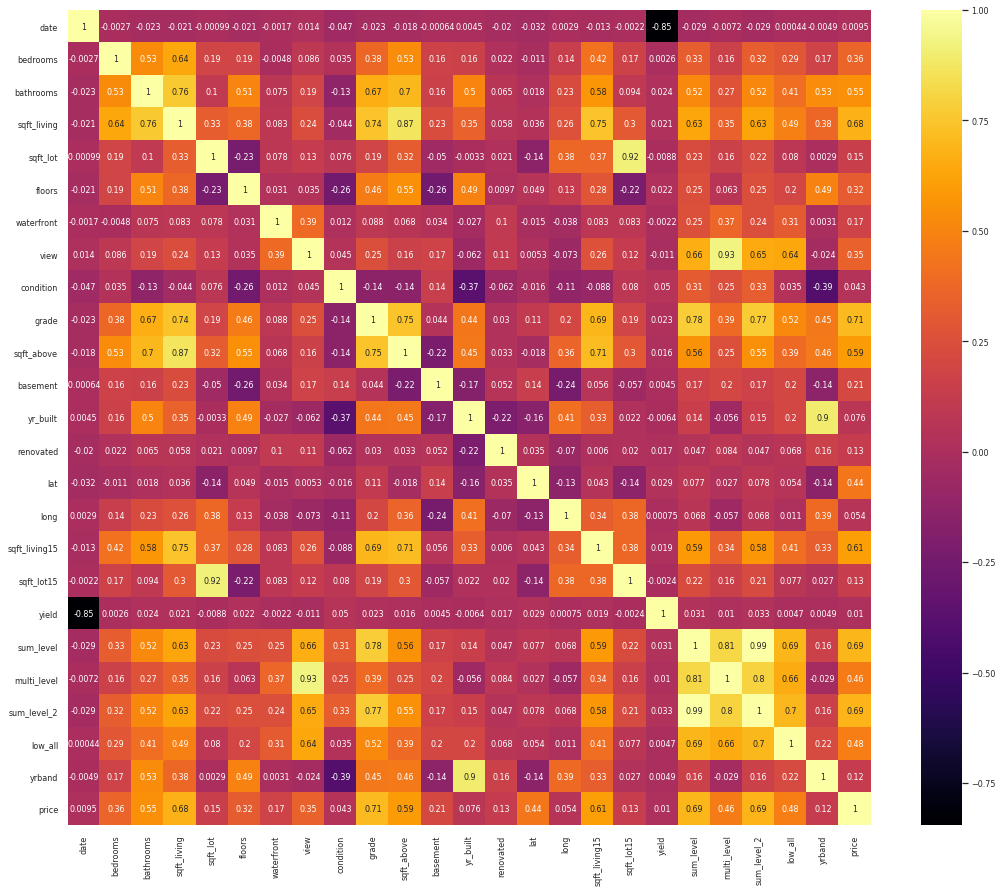

time: 4.23 s (started: 2021-08-09 12:48:52 +00:00)


In [290]:
data_copy = data.copy()
data_copy['price'] = y.values
plt.figure(figsize=(18,15))
cor = data_copy.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.inferno)
plt.show()

In [291]:
sub.columns

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'basement',
       'yr_built', 'renovated', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'yield', 'city', 'zipcode-3', 'zipcode-4', 'zipcode-5',
       'zipcode-34', 'zipcode-45', 'zipcode-35', 'sum_level', 'multi_level',
       'sum_level_2', 'low_all', 'yrband'],
      dtype='object')

time: 2.33 ms (started: 2021-08-09 12:51:29 +00:00)


In [293]:
del data['zipcode'], sub['zipcode'] 

time: 4.8 ms (started: 2021-08-09 12:52:57 +00:00)


In [292]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
data[["lat", "long", "yield"]] = standard_scaler.fit_transform(data[["lat", "long", "yield"]])
sub[["lat", "long", "yield"]] = standard_scaler.fit_transform(sub[["lat", "long", "yield"]])

time: 23.3 ms (started: 2021-08-09 12:51:46 +00:00)


In [294]:
data_dummies = pd.get_dummies(data=data, columns=['date','city', 'yrband', 'zipcode-3', 'zipcode-4', 'zipcode-5',
       'zipcode-34', 'zipcode-45', 'zipcode-35'],drop_first=True, dtype=int)
data_onehot = data_dummies

sub_dummies = pd.get_dummies(data=sub, columns=['date', 'city', 'yrband', 'zipcode-3', 'zipcode-4', 'zipcode-5',
       'zipcode-34', 'zipcode-45', 'zipcode-35'], drop_first=True, dtype=int)
sub_onehot = sub_dummies
data_onehot, sub_onehot = data_onehot.align(sub_onehot, join='left', fill_value=0, axis=1)

time: 78.7 ms (started: 2021-08-09 12:53:05 +00:00)


In [295]:
data_onehot.shape

(15035, 166)

time: 1.7 ms (started: 2021-08-09 12:53:07 +00:00)


In [296]:
sub_onehot.shape

(6468, 166)

time: 1.79 ms (started: 2021-08-09 12:53:08 +00:00)


In [297]:
data_onehot.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       ...
       'zipcode-35_z_08', 'zipcode-35_z_09', 'zipcode-35_z_12',
       'zipcode-35_z_13', 'zipcode-35_z_14', 'zipcode-35_z_15',
       'zipcode-35_z_16', 'zipcode-35_z_17', 'zipcode-35_z_18',
       'zipcode-35_z_19'],
      dtype='object', length=166)

time: 2.06 ms (started: 2021-08-09 12:53:10 +00:00)


In [298]:
sub_onehot.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       ...
       'zipcode-35_z_08', 'zipcode-35_z_09', 'zipcode-35_z_12',
       'zipcode-35_z_13', 'zipcode-35_z_14', 'zipcode-35_z_15',
       'zipcode-35_z_16', 'zipcode-35_z_17', 'zipcode-35_z_18',
       'zipcode-35_z_19'],
      dtype='object', length=166)

time: 2.36 ms (started: 2021-08-09 12:53:12 +00:00)


In [299]:
param_grid = {
    'n_estimators': [250, 275, 300, 325, 350],
    'max_depth': [7, 10, 15],
    'num_leaves': [31, 63, 127]
}
random_state=2021
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, data_onehot, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    9.6s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   49.2s
[Parallel(n_jobs=5)]: Done 225 out of 225 | elapsed:  1.3min finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,max_depth,n_estimators,num_leaves,score,RMSLE
30,15,250,31,-0.026156,0.161728
33,15,275,31,-0.026162,0.161748
42,15,350,31,-0.026183,0.161811
39,15,325,31,-0.026189,0.161830
18,10,275,31,-0.026202,0.161872
21,10,300,31,-0.026207,0.161885
36,15,300,31,-0.026215,0.161911
15,10,250,31,-0.026230,0.161956
4,7,275,63,-0.026233,0.161966
24,10,325,31,-0.026239,0.161985


time: 1min 19s (started: 2021-08-09 12:53:21 +00:00)


In [300]:
def plotImp(model, X , num = 10, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

time: 773 µs (started: 2021-08-09 12:55:07 +00:00)


In [302]:
model = LGBMRegressor(random_state=random_state, max_depth=15, n_estimators=250)
model.fit(data_onehot, y)

LGBMRegressor(max_depth=15, n_estimators=250, random_state=2021)

time: 603 ms (started: 2021-08-09 12:55:20 +00:00)


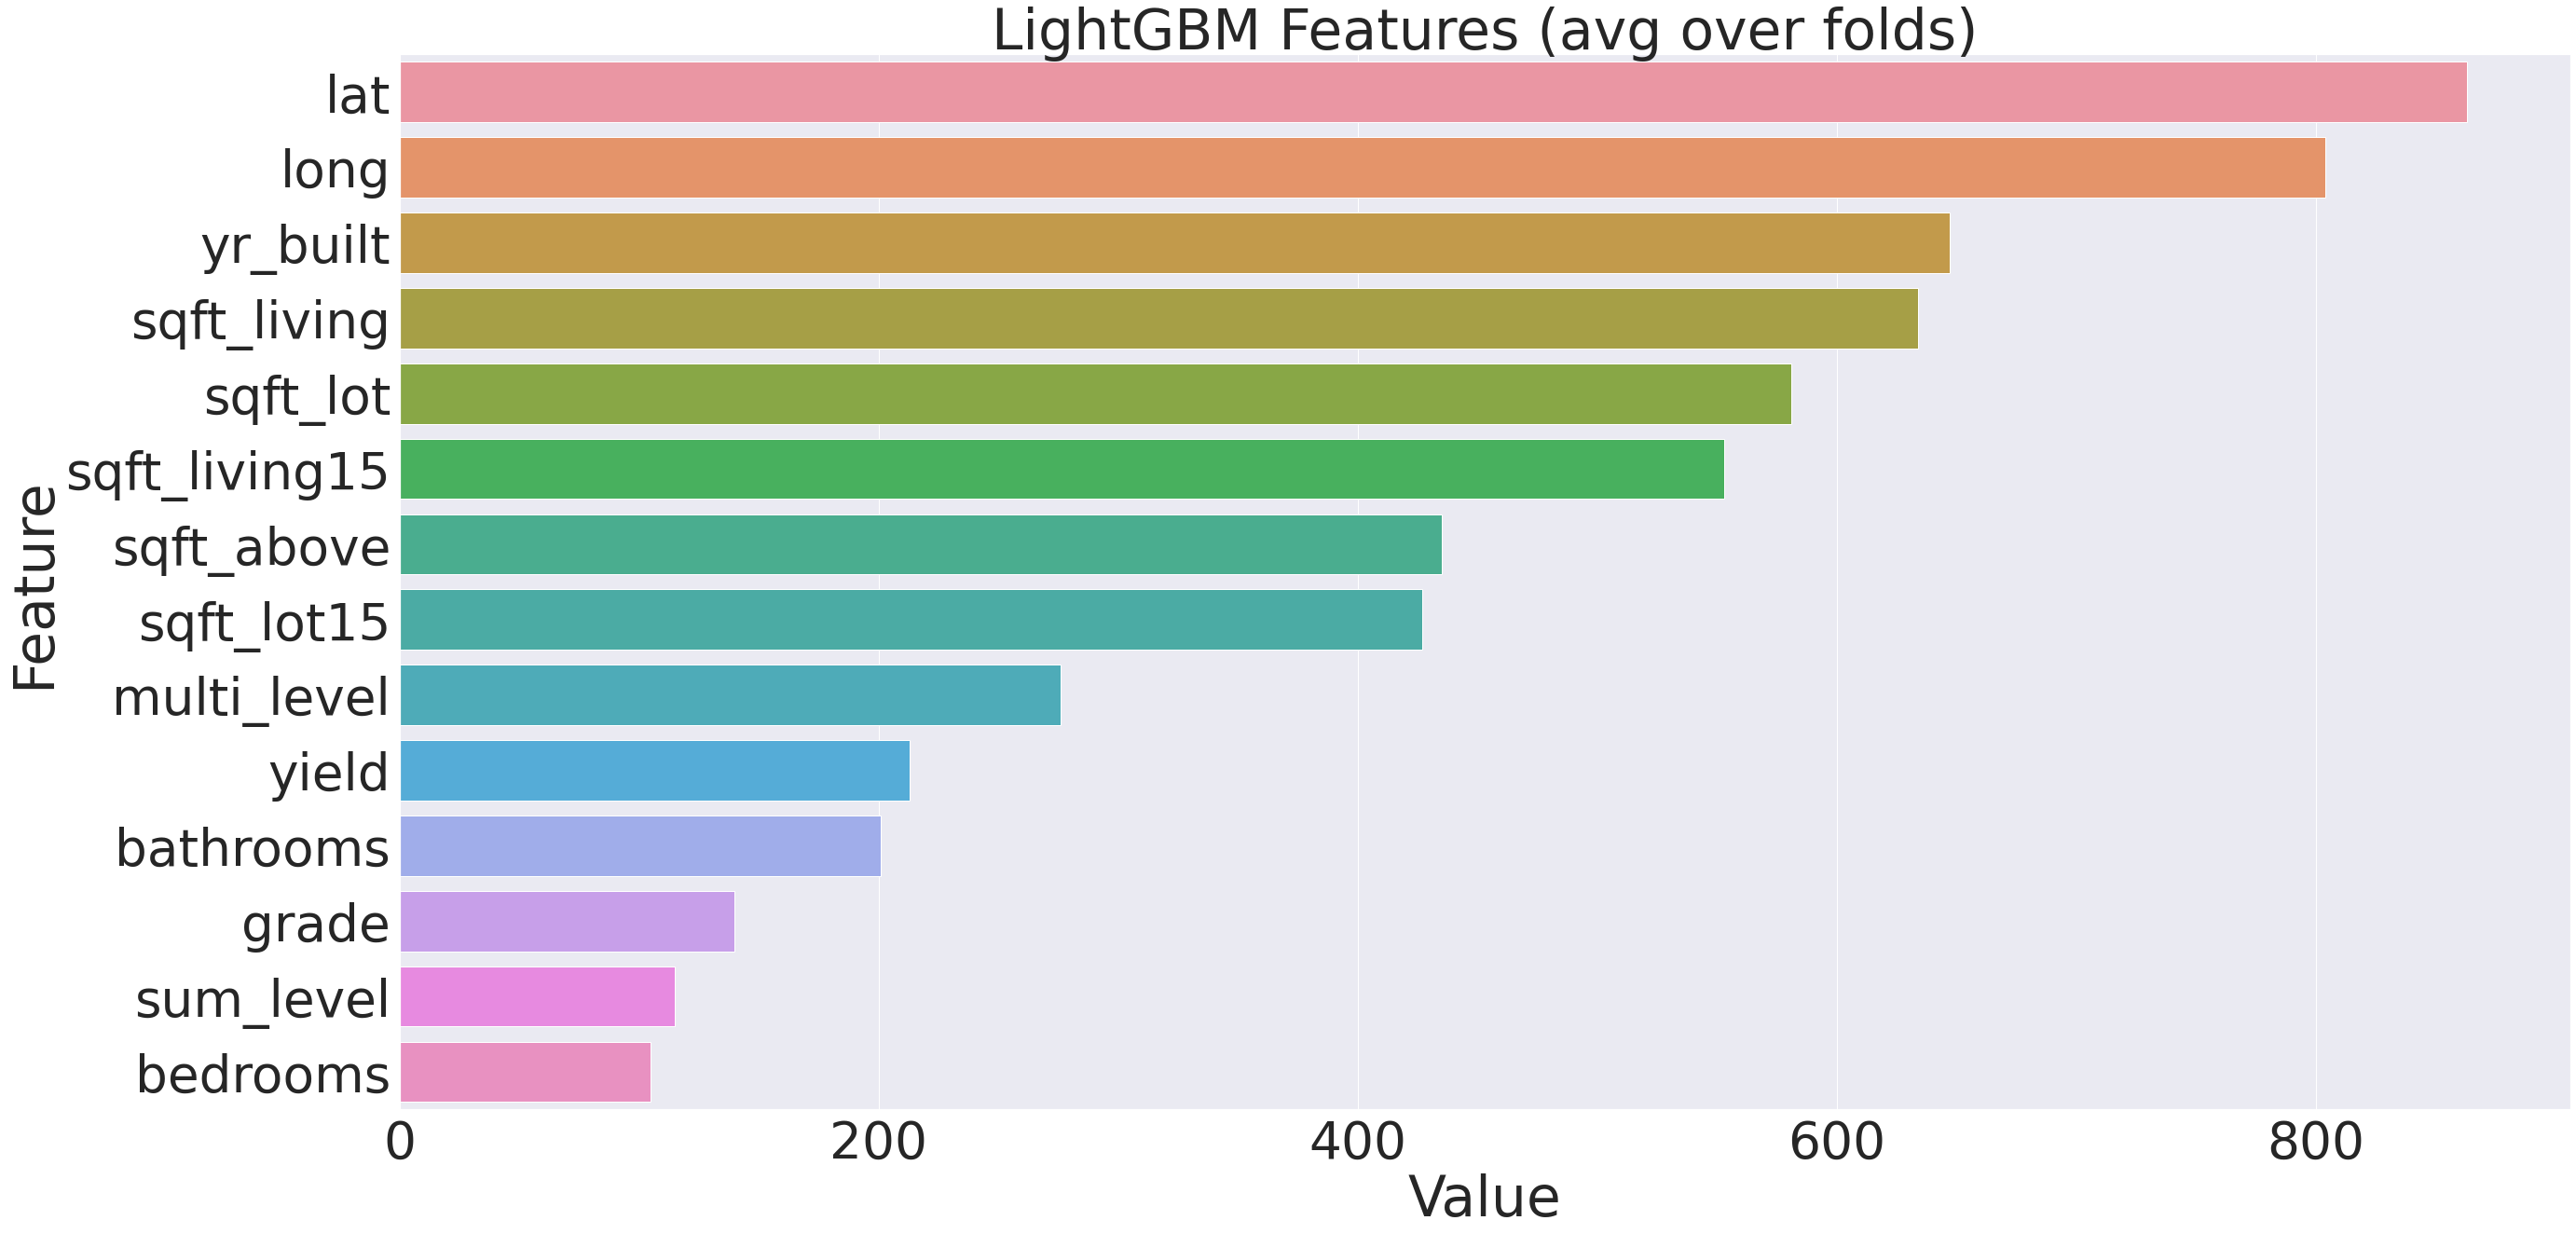

time: 885 ms (started: 2021-08-09 12:55:21 +00:00)


In [303]:
plotImp(model, data_onehot, num=14)

In [304]:
model.feature_importances_

array([105, 201, 634, 581,  59,  33,  39,  64, 140, 435,  50, 647,  35,
       863, 804, 553, 427, 213, 115, 276,  38,  45,   9,   0,   9,   4,
         5,   8,   8,   0,   9,  16,  22,  21,  15,   5,   1,  22,   9,
         5,   5,   1,   2,   6,   8,  13,  13,   0,  26,  15,  20,  22,
        18,  33,   7,  12,   6,  11,  14,   6,   3,   4,   1,   3,   9,
         9,  10,  11,   9,  14,   6,  34,  11,  12,   5,   1,   6,   6,
         4,   1,   0,  24,  16,   4,   6,   9,   4,   3,   7,   0,   4,
         0,  15,  34,   8,  26,   2,   8,  10,  11,   3,  11,  23,   2,
         1,   1,   4,  13,   3,   1,   7,   2,  11,   5,   5,   0,   0,
         0,   5,   4,   0,  13,   7,  18,  20,   9,   2,   2,  10,   9,
         3,  12,  12,   5,   2,   5,   0,  18,  11,   0,   3,   4,   1,
        12,   8,   0,   0,   4,   8,   0,   3,   2,   4,   8,   4,   0,
         7,   0,  26,   1,   0,   1,   2,   1,  18,  11], dtype=int32)

time: 2.4 ms (started: 2021-08-09 12:55:28 +00:00)


In [305]:
important_features = np.where(model.feature_importances_>30)
important_features[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 53, 71, 93])

time: 2.51 ms (started: 2021-08-09 12:55:39 +00:00)


In [306]:
data_onehot_cut = data_onehot.iloc[:, important_features[0]]
data_onehot_cut, sub_onehot_cut = data_onehot_cut.align(sub_onehot, join='left', fill_value=0, axis=1)

time: 18.9 ms (started: 2021-08-09 12:55:40 +00:00)


In [210]:
data_onehot_cut

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,basement,...,sqft_lot15,yield,sum_level,multi_level,sum_level_2,low_all,city_other,yrband_2,yrband_4,yrband_5
0,3,1.00,7.074117,8.639588,1.0,0,3,7,7.074117,0,...,8.639588,0.297001,10,21,10,4,0,1,0,0
1,2,1.00,6.647688,9.210440,1.0,0,3,6,6.647688,0,...,8.995041,-1.034939,9,18,9,3,1,0,0,0
2,3,2.00,7.427144,8.997271,1.0,0,3,8,7.427144,0,...,8.923191,-1.034939,11,24,11,4,0,0,1,0
3,3,2.25,7.447751,8.827615,2.0,0,3,7,7.447751,0,...,8.827615,1.073309,10,21,10,4,1,0,1,0
4,3,1.50,6.966967,9.181118,1.0,0,3,7,6.966967,0,...,9.181118,-2.445691,10,21,10,4,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,4,2.50,7.832411,8.703507,2.0,0,3,9,7.832411,0,...,8.703507,0.297001,12,27,12,4,0,0,0,1
15031,4,3.50,8.163656,8.881975,2.0,0,3,9,7.863651,1,...,8.732466,-1.310784,12,27,12,4,0,0,0,1
15032,3,2.50,7.333676,7.031741,3.0,0,3,8,7.333676,0,...,7.319865,0.848692,11,24,11,4,0,0,0,1
15033,4,2.50,7.745436,8.668024,2.0,0,3,8,7.745436,0,...,8.881975,-1.034939,11,24,11,4,0,0,0,1


time: 33.6 ms (started: 2021-08-09 10:40:14 +00:00)


In [307]:
param_grid = {
    'n_estimators': [250, 275, 300, 325, 350],
    'max_depth': [7, 10, 15],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, data_onehot_cut, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    6.5s
[Parallel(n_jobs=5)]: Done  75 out of  75 | elapsed:   14.8s finished


,max_depth,n_estimators,score,RMSLE
4,7,350,-0.026621,0.163160
2,7,300,-0.026630,0.163187
3,7,325,-0.026634,0.163198
0,7,250,-0.026646,0.163235
1,7,275,-0.026647,0.163238
11,15,275,-0.026689,0.163369
10,15,250,-0.026692,0.163376
12,15,300,-0.026693,0.163381
14,15,350,-0.026697,0.163392
7,10,300,-0.026698,0.163394


time: 15.5 s (started: 2021-08-09 12:55:51 +00:00)


In [212]:
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

get_scores(models, data_onehot, y)

,RMSE
GradientBoostingRegressor,135881.479967
RandomForestRegressor,135434.155558
LGBMRegressor,129375.002091
XGBRegressor,124932.474567


time: 15.6 s (started: 2021-08-09 10:41:37 +00:00)


In [213]:
get_scores(models, data_onehot_cut, y)

,RMSE
GradientBoostingRegressor,137172.355301
RandomForestRegressor,134879.767757
LGBMRegressor,127920.328828
XGBRegressor,123021.886797


time: 13.3 s (started: 2021-08-09 10:41:53 +00:00)


In [ ]:
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission['price'] = y_pred
submission

In [ ]:
submission.to_csv("xgb_08_09.csv", index=False)

In [58]:
data_onehot.dtypes

bedrooms            int64
bathrooms         float64
sqft_living       float64
sqft_lot          float64
floors            float64
view                int64
sqft_above        float64
basement            int64
yr_built          float64
renovated           int64
lat               float64
long              float64
sqft_living15     float64
sqft_lot15        float64
yield             float64
date_201406         int64
date_201407         int64
date_201408         int64
date_201409         int64
date_201410         int64
date_201411         int64
date_201412         int64
date_201501         int64
date_201502         int64
date_201503         int64
date_201504         int64
date_201505         int64
city_Kent           int64
city_Kirkland       int64
city_Renton         int64
city_Sammamish      int64
city_Seattle        int64
city_other          int64
yrband_1            int64
yrband_2            int64
yrband_3            int64
yrband_4            int64
yrband_5            int64
grade_3     

time: 4.34 ms (started: 2021-08-09 04:49:36 +00:00)


In [ ]:
!pip install ray[tune]

In [ ]:
import sklearn.datasets
import sklearn.metrics
import os
from ray.tune.schedulers import ASHAScheduler
from sklearn.model_selection import train_test_split
import xgboost as xgb
import ray
from ray import tune
from ray.tune.integration.xgboost import TuneReportCheckpointCallback


def train_price(config: dict):
    # This is a simple training function to be passed into Tune
    # Split into train and test set
    train_x, test_x, train_y, test_y = train_test_split(
        data_onehot, y, test_size=0.25)
    # Build input matrices for XGBoost
    train_set = xgb.DMatrix(train_x, label=train_y, enable_categorical=True)
    test_set = xgb.DMatrix(test_x, label=test_y, enable_categorical=True)
    # Train the classifier, using the Tune callback
    xgb.train(
        config,
        train_set,
        evals=[(test_set, "eval")],
        verbose_eval=False,
        callbacks=[TuneReportCheckpointCallback(filename="model.xgb")])


def get_best_model_checkpoint(analysis):
    best_price_model = xgb.Booster()
    best_price_model.load_model(os.path.join(analysis.best_checkpoint, "model.xgb"))
    error =analysis.best_result["eval-rmsle"]
    print(f"Best model parameters: {analysis.best_config}")
    print(f"Best model rmsle: {error:.4f}")
    return best_price_model


def tune_xgboost():
    search_space = {
        # You can mix constants with search space objects.
        "objective": "reg:squarederror",
        "eval_metric": ["rmsle"],
        "max_depth": tune.randint(3,9),
        "min_child_weight": tune.choice([1, 2, 3]),
        "subsample": tune.uniform(0.5, 1.0),
        "eta": tune.loguniform(1e-4, 2e-2),
        "booster": 'gbtree'
    }
    # This will enable aggressive early stopping of bad trials.
    scheduler = ASHAScheduler(
        max_t=100,  # 40 training iterations
        grace_period=4,
        reduction_factor=2)

    analysis = tune.run(
        train_price,
        metric="eval-rmsle",
        mode="min",
        # You can add "gpu": 0.1 to allocate GPUs
        resources_per_trial={"cpu": 4, "gpu": 0.8},
        config=search_space,
        num_samples=80,
        scheduler=scheduler)

    return analysis

ray.shutdown()  # Restart Ray defensively in case the ray connection is lost. 
ray.init(log_to_driver=False)


if __name__ == "__main__":
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "--server-address",
        type=str,
        default=None,
        required=False,
        help="The address of server to connect to if using "
        "Ray Client.")
    args, _ = parser.parse_known_args()

    if args.server_address:
        import ray
        ray.init(f"ray://{args.server_address}")

    analysis = tune_xgboost()

    # Load the best model checkpoint.
    if args.server_address:
        # If connecting to a remote server with Ray Client, checkpoint loading
        # should be wrapped in a task so it will execute on the server.
        # We have to make sure it gets executed on the same node that
        # ``tune.run`` is called on.
        from ray.tune.utils import force_on_current_node
        remote_fn = force_on_current_node(
            ray.remote(get_best_model_checkpoint))
        best_bst = ray.get(remote_fn.remote(analysis))
    else:
        best_bst = get_best_model_checkpoint(analysis)


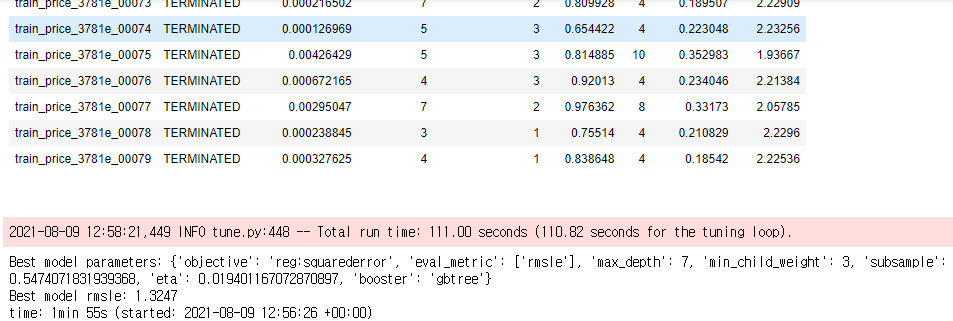

In [309]:
analysis.best_config

{'objective': 'reg:squarederror',
 'eval_metric': ['rmsle'],
 'max_depth': 7,
 'min_child_weight': 3,
 'subsample': 0.5474071831939368,
 'eta': 0.019401167072870897,
 'booster': 'gbtree'}

time: 2.53 ms (started: 2021-08-09 12:58:34 +00:00)


In [310]:
import pickle
pickle.dump(best_bst, open("xgb_last.pkl", "wb"))
loaded_bst = pickle.load(open("xgb_last.pkl", "rb"))

time: 3.2 ms (started: 2021-08-09 12:58:49 +00:00)


In [311]:
dtrain = xgb.DMatrix(data_onehot, label=y, enable_categorical=True)
dtest = xgb.DMatrix(sub_onehot, enable_categorical=True)
# y_pred = loaded_bst.predict(train_set)

time: 33.7 ms (started: 2021-08-09 12:58:51 +00:00)


In [312]:
params = analysis.best_config

num_rounds = 300

# train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval' 로 명기
# wlist = [(dtrain, 'train'), (dtest,'eval')]
# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params = params, dtrain=dtrain, num_boost_round=num_rounds)

time: 10.5 s (started: 2021-08-09 12:59:00 +00:00)


In [313]:
# Feval(RMSE_exp)
def rmse_exp(predictions, dmat):
    labels = dmat.get_label()
    diffs = np.exp(predictions) - np.exp(labels)
    squared_diffs = np.square(diffs)
    avg = np.mean(squared_diffs)
    return ('rmse_exp', np.sqrt(avg))

time: 551 µs (started: 2021-08-09 12:59:22 +00:00)


In [314]:
rmse_exp(xgb_model.predict(dtrain), dtrain)

('rmse_exp', 115659.18)

time: 30.8 ms (started: 2021-08-09 12:59:23 +00:00)


In [315]:
params

{'objective': 'reg:squarederror',
 'eval_metric': ['rmsle'],
 'max_depth': 7,
 'min_child_weight': 3,
 'subsample': 0.5474071831939368,
 'eta': 0.019401167072870897,
 'booster': 'gbtree'}

time: 1.95 ms (started: 2021-08-09 12:59:27 +00:00)


In [316]:
cv_output = xgb.cv(params,
                   dtrain,                        
                   num_boost_round=5000,         # 학습 횟수
                   early_stopping_rounds=10,    # overfitting 방지
                   nfold=10,                      # 높을 수록 실제 검증값에 가까워지고 낮을 수록 빠름
                   verbose_eval=100,             # 몇 번째마다 메세지를 출력할 것인지
                   feval=rmse_exp,               # price 속성을 log scaling 했기 때문에, 다시 exponential
                   maximize=False,
                   show_stdv=False,              # 학습 동안 std(표준편차) 출력할지 말지
                   )
# scoring
best_rounds = cv_output.index.size
score = round(cv_output.iloc[-1]['test-rmse_exp-mean'], 2)

print(f'\nBest Rounds: {best_rounds}')
print(f'Best Score: {score}')


Best Rounds: 1182
Best Score: 112322.07
time: 7min 19s (started: 2021-08-09 12:59:36 +00:00)


In [317]:
model = xgb.train(params, dtrain, num_boost_round=best_rounds)
y_pred = model.predict(dtest)
y_pred = np.expm1(y_pred)
y_pred

array([ 521577.28,  495891.66, 1363136.2 , ...,  468611.88,  301350.2 ,
        444668.22], dtype=float32)

time: 46.4 s (started: 2021-08-09 13:13:21 +00:00)


In [318]:
import matplotlib.pyplot as plt 

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

time: 861 µs (started: 2021-08-09 13:14:07 +00:00)


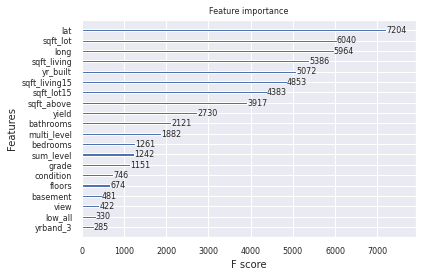

time: 1.05 s (started: 2021-08-09 13:14:07 +00:00)


In [319]:
from xgboost import plot_importance
plot_importance(model, max_num_features=20)
plt.show()

In [236]:
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission['price'] = y_pred
submission

,id,price
0,15035,5.189976e+05
1,15036,4.229063e+05
2,15037,1.356422e+06
3,15038,3.253039e+05
4,15039,3.272162e+05
...,...,...
6463,21498,2.452759e+05
6464,21499,4.181516e+05
6465,21500,4.484782e+05
6466,21501,3.045720e+05


time: 12.9 ms (started: 2021-08-09 11:16:03 +00:00)


In [237]:
submission.to_csv("xgb_lastlast.csv", index=False)

time: 12.7 ms (started: 2021-08-09 11:16:10 +00:00)


In [238]:
submission

,id,price
0,15035,5.189976e+05
1,15036,4.229063e+05
2,15037,1.356422e+06
3,15038,3.253039e+05
4,15039,3.272162e+05
...,...,...
6463,21498,2.452759e+05
6464,21499,4.181516e+05
6465,21500,4.484782e+05
6466,21501,3.045720e+05


time: 13.3 ms (started: 2021-08-09 11:16:12 +00:00)


In [320]:
lgb_model = lgb.LGBMRegressor(objective='regression',num_leaves=25, n_estimators=325, boosting_type ='gbdt', max_depth = 6,
    colsample_bytree = 0.4,
    subsample = 0.4,
    max_bin = 80
)

lgb_model.fit(data_onehot, y)
y_LGB_predict = lgb_model.predict(sub_onehot)
y_LGB_predict = np.expm1(y_LGB_predict)
y_LGB_predict
# LGB_model_error = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_LGB_predict)))


array([ 530270.76629029,  481032.54779189, 1370584.79932653, ...,
        487404.55660841,  298830.16253148,  457489.43657911])

time: 569 ms (started: 2021-08-09 13:17:22 +00:00)


In [321]:
for i in range(11):
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = i/10 * y_pred + (1-i/10) * y_LGB_predict
    submission.to_csv(f"ensemble3_{i}.csv", index=False)

time: 184 ms (started: 2021-08-09 13:17:24 +00:00)


## 108398.86 의 결과를 얻었다

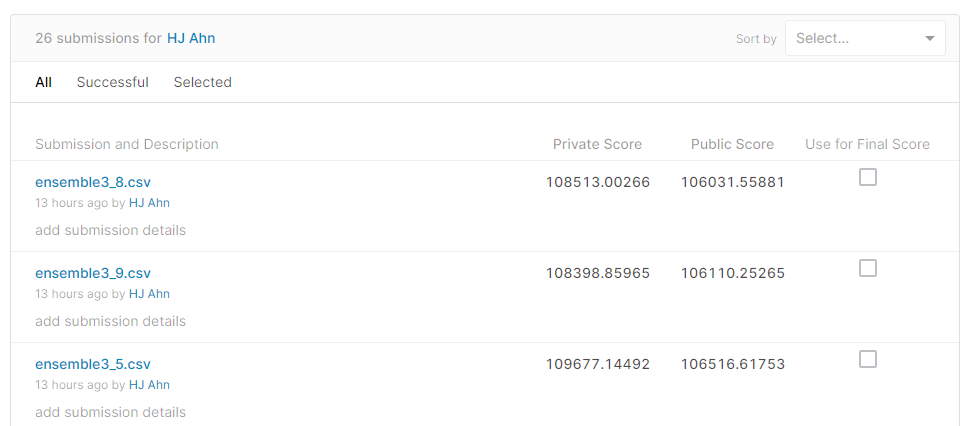

# 회고

1. 데이터를 없애는 것보다, 데이터 간의 상관관계를 직접 찾아 모델에 그 관계를 알려주는 것이 매우 중요했다. 그 동안 착각하고 있던 부분이라 신기했고, 머신러닝과 딥러닝의 차이를 느낄 수 있었다

2. 모델의 학습 능력에 대해서 조금이나마 감각을 얻을 수 있었고, 앙상블 기법을 간단하게 사용해 보았다